In [1]:
import os
import re

# Pre-requisites
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Store the classifier models 
import joblib

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Classifiers from scikit-learn
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR

from xgboost import XGBRegressor

# Performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pointbiserialr


In [2]:
df = pd.read_csv('data/ready_df_with_dep.csv')
df.head()

,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,DepDelay,DepDel15,DepTimeBlk,...,dep_time_shift_sin,dep_time_shift_cos,is_night_departure,is_evening_departure,low_visibility,strong_wind,wind_gust,bad_weather_score,is_hub_route,is_roundtrip
0,1,1,1,1,AA,SDF,MIA,0.0,0.0,0001-0559,...,0.000000,0.000000,0,0,0,0,0,0,0,1
1,1,1,1,1,NK,SDF,LAS,-7.0,0.0,0600-0659,...,-0.000466,0.030539,0,0,0,0,0,0,0,1
2,1,1,1,1,DL,SDF,ATL,-4.0,0.0,0600-0659,...,-0.000152,0.017452,0,0,0,0,0,0,1,1
3,1,1,1,1,WN,SDF,MCO,-4.0,0.0,0600-0659,...,0.000228,0.017452,0,0,0,0,0,0,0,1
4,1,1,1,1,AA,SDF,CLT,18.0,1.0,0600-0659,...,-0.009229,-0.077975,0,0,0,0,0,0,1,1


In [3]:
df = df.drop(columns=['Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'ArrDel15'])

In [4]:
df.shape[1]

54

---

# Scaling and encoding (OHE)

In [5]:
num_features = ["dep_delay_ratio", "bad_weather_score", "dep_time_shift_sin", "dep_time_shift_cos", "DepDelay", "TaxiOut", "CRSElapsedTime", "Distance", "DistanceGroup", "HourlyDewPointTemperature", "HourlyDryBulbTemperature", "HourlyPrecipitation", "HourlyRelativeHumidity", "HourlySeaLevelPressure", "HourlyVisibility", "HourlyWindGustSpeed", "HourlyWindSpeed", "wind_dir_sin", "wind_dir_cos", "WheelsOff_sin", "WheelsOff_cos", "CRSArrTime_sin", "CRSArrTime_cos", "CRSDepTime_sin", "CRSDepTime_cos", "DepTime_sin", "DepTime_cos", "Quarter_sin", "Quarter_cos", "Month_sin", "Month_cos", "DayofMonth_sin", "DayofMonth_cos", "DayOfWeek_sin", "DayOfWeek_cos"]

cat_features = ["Reporting_Airline", "Origin", "Dest", "DepTimeBlk", "HourlyWeatherType", "HourlySkyCondit"]

pass_features = ["dep_delay_gt30", "dep_delay_gt60", "taxiout_long", "is_night_departure", "is_evening_departure", "low_visibility", "strong_wind", "wind_gust", "is_hub_route", "is_roundtrip", "wind_dir_vrb", "DepDel15"]

In [6]:
len(num_features + cat_features + pass_features)

53

In [7]:
X = df.drop(columns=['ArrDelayMinutes'], axis=1)
y = df['ArrDelayMinutes'].copy()
X.shape, y.shape

((47518, 53), (47518,))

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=0)

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('bin', 'passthrough', pass_features),
    ]
)

In [10]:
def make_pipe(model, use_smote=False, use_fs=False, k=209, random_state=33):
    steps = [("preprocess", preprocessor)]
    
    if use_fs:
        steps.append(("select", SelectKBest(score_func=f_classif, k=k)))
        
    if use_smote:
        steps.append(("smote", SMOTE(random_state=random_state)))
        steps.append(("model", model))
        return ImbPipeline(steps)
    else:
        steps.append(("model", model))
        return Pipeline(steps)

---

In [11]:
X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_valid_encoded = preprocessor.transform(X_valid)

ohe = preprocessor.named_transformers_['cat']
cat_ohe_names = ohe.get_feature_names_out(cat_features)

final_feature_names = (
        np.array(num_features, dtype=object).tolist()
        + cat_ohe_names.tolist()
        + pass_features
)
print("Final feature count:", len(final_feature_names))
#print("Example names:", final_feature_names[50:])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=final_feature_names, index=X_train.index)
X_valid_encoded = pd.DataFrame(X_valid_encoded, columns=final_feature_names, index=X_valid.index)

X_train_encoded_features = X_train_encoded.columns.tolist()

Final feature count: 164


---

## Save model function

In [12]:
def save_model(model_name, scores_df, scoring, rs, num_cv, model_clf=None, grid=None):
    if model_clf:
        artifact = {
            "model": model_clf,
            "scores_df": scores_df,
            "scoring": scoring,
            "random_state": rs,
            "cv_splits": num_cv
        }
    
    if grid:
        artifact = {
            "model": grid.best_estimator_,
            "best_params": grid.best_params_,
            "cv_results": grid.cv_results_,
            "scores_df": scores_df,
            "scoring": scoring,
            "random_state": rs,
            "cv_splits": num_cv
        }

    joblib.dump(artifact, f"models/regr/{model_name}_dep_regr_artifact.joblib")

In [13]:
def save_model(model_name, scores_df, scoring, rs, num_cv, model_clf=None, grid=None):
    """
    Save a trained regression model artifact to disk.

    The function supports saving either:
    - A fitted standalone model (model_clf), or
    - A fitted GridSearchCV object (grid), including best parameters and CV results.

    The saved artifact contains the trained model along with evaluation
    metrics and configuration metadata.

    Args:
        model_name (str): Name of the model used for the output filename.
        scores_df (pd.DataFrame): DataFrame with evaluation metrics.
        scoring (str): Scoring metric used during training or model selection.
        rs (int): Random state used for reproducibility.
        num_cv (int): Number of cross-validation splits.
        model_clf (optional): Fitted regression model.
        grid (GridSearchCV, optional): Fitted GridSearchCV object.

    Returns:
        None

    Raises:
        ValueError: If neither model_clf nor grid is provided.
    """

    if model_clf is None and grid is None:
        raise ValueError("Either 'model_clf' or 'grid' must be provided.")

    if grid is not None:
        artifact = {
            "model": grid.best_estimator_,
            "best_params": grid.best_params_,
            "cv_results": grid.cv_results_,
            "scores_df": scores_df,
            "scoring": scoring,
            "random_state": rs,
            "cv_splits": num_cv
        }
    else:
        artifact = {
            "model": model_clf,
            "scores_df": scores_df,
            "scoring": scoring,
            "random_state": rs,
            "cv_splits": num_cv
        }

    os.makedirs("models/regr", exist_ok=True)
    joblib.dump(artifact, f"models/regr/{model_name}_dep_regr_artifact.joblib")

## Validation curves function

In [14]:
def plot_fixed_param_curve(grid, vary_key, title, xlabel, xscale="linear", markers=True, save=False,
                           save_dir="img/regr/val_curves", dpi=300, fmt='png'):
    """
    Plot a validation curve for a single hyperparameter from a fitted GridSearchCV (regression).

    The function extracts cross-validation results from the provided GridSearchCV object
    and visualizes how the training and validation scores change as one selected
    hyperparameter varies, while all other hyperparameters are fixed at their best values.

    Args:
        grid (GridSearchCV): Fitted GridSearchCV object.
        vary_key (str): Name of the hyperparameter to visualize.
        title (str): Plot title.
        xlabel (str): Label for the x-axis (hyperparameter name).
        xscale (str, optional): Scale of the x-axis ("linear", "log", etc.).
            Defaults to "linear".
        markers (bool, optional): Whether to display markers on the curves.
            Defaults to True.
        save (bool, optional): Whether to save the plot to disk.
            Defaults to False.
        save_dir (str, optional): Directory where the plot will be saved.
            Defaults to "validation_curves/regr".
        dpi (int, optional): Resolution of the saved figure.
            Defaults to 300.
        fmt (str, optional): File format for saving (e.g., "png", "svg").
            Defaults to "png".

    Returns:
        None

    Notes:
        - Only parameter combinations where all other hyperparameters match
          the best configuration are plotted.
        - The vertical dashed line indicates the best value of the selected parameter.
        - Assumes that scoring was configured appropriately for regression
          (e.g., neg_mean_squared_error, r2, etc.).
    """
    
    cvres = grid.cv_results_
    params_list = cvres["params"]
    best_params = grid.best_params_.copy()

    # mask
    mask = []
    for p in params_list:
        ok = True
        for k, v in best_params.items():
            if k == vary_key:
                continue
            if p.get(k) != v:
                ok = False
                break
        mask.append(ok)
    mask = np.array(mask, dtype=bool)

    x_vals = np.array([params_list[i][vary_key] for i in range(len(params_list)) if mask[i]])

    train_mean = np.array(cvres["mean_train_score"])[mask]
    train_std  = np.array(cvres["std_train_score"])[mask]
    val_mean   = np.array(cvres["mean_test_score"])[mask]
    val_std    = np.array(cvres["std_test_score"])[mask]

    order = np.argsort(x_vals.astype(float))
    x_vals = x_vals[order]
    train_mean, train_std = train_mean[order], train_std[order]
    val_mean, val_std     = val_mean[order], val_std[order]

    best_x = grid.best_params_[vary_key]

    # marker style
    marker_style = 'o' if markers else None
    
    plt.figure(figsize=(9, 5))
    plt.plot(x_vals, train_mean, marker=marker_style, label="Train (mean)")
    plt.fill_between(x_vals, train_mean - train_std, train_mean + train_std, alpha=0.2)

    plt.plot(x_vals, val_mean, marker=marker_style, label="CV (mean)")
    plt.fill_between(x_vals, val_mean - val_std, val_mean + val_std, alpha=0.2)

    plt.axvline(best_x, linestyle="--", linewidth=1, label=f"Best = {best_x}")

    plt.xscale(xscale)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Average precision")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    
    if save:
        os.makedirs(save_dir, exist_ok=True)

        safe_title = title.lower().replace(" ", "_").replace(":", "")
        fname = f"{safe_title}_regr_{vary_key}.{fmt}"
        path = os.path.join(save_dir, fname)

        plt.savefig(path, dpi=dpi, bbox_inches="tight")
        print(f"Saved plot → {path}")
        
    plt.show()

## Evaluation Function

In [15]:
def model_evaluation(
    model_name,
    best_estimator,
    X_valid,
    y_valid,
    *,
    pred_clip=None,                 # e.g. (-60, 600) to clip crazy predictions; None = no clipping
    scatter_plot=False,             # y_true vs y_pred
    resid_plot=False,               # residuals vs y_pred
    save_plots=False,
    save_dir="img/regr/reg_plots",
    fmt="png",
    dpi=300,
):
    """
    Evaluate a REGRESSION model on validation data using common error and fit metrics.

    Metrics returned (and printed):
      - MAE  (Mean Absolute Error): average |y - ŷ| in target units (minutes). Lower is better.
      - MSE  (Mean Squared Error): average (y - ŷ)^2. Penalizes large errors strongly. Lower is better.
      - RMSE (Root MSE): sqrt(MSE), in target units. Lower is better.
      - RAE  (Relative Absolute Error): sum|y-ŷ| / sum|y-ȳ|. <1 beats predicting the mean.
      - RRSE (Root Relative Squared Error): sqrt( sum(y-ŷ)^2 / sum(y-ȳ)^2 ). <1 beats mean baseline.
      - R2   (Coefficient of determination): 1 - SSE/SST. 0 = mean baseline, 1 = perfect, can be negative.
      - Corr (Pearson correlation between y and ŷ): measures linear association (-1..1). Higher |corr| is better.

    Notes:
      - RAE/RRSE are scale-free and compare you to a naive predictor ŷ = mean(y).
      - Corr can be high even if predictions are biased (e.g., consistently underpredicting).
      - If your target is "delay in minutes" and may be negative, these metrics still work as-is.
    """
    # Predict 
    y_pred = best_estimator.predict(X_valid)
    y_true = np.asarray(y_valid)

    # Optional: clip predictions (useful if you occasionally get absurd values)
    if pred_clip is not None:
        lo, hi = pred_clip
        y_pred = np.clip(y_pred, lo, hi)


    # Relative errors vs mean baseline 
    # Avoid divide-by-zero when y_true is constant (rare but possible)
    eps = 1e-12
    
    y_mean = float(np.mean(y_true))
    res = y_true - y_pred
    sq_error = (y_true - y_pred)**2
    abs_error = np.abs(y_true - y_pred)
    #abs_perc_error = np.abs((y_true - y_pred) / y_true + eps) * 100
    sape = 200 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + eps)

    mse = np.sum(sq_error) / len(y_true)
    rmse = np.sqrt(mse)

    mae = np.sum(abs_error) / len(y_true)
    
    # Cant use these metrics as Actual value can be zero
    #mape = np.sum(abs_perc_error) / len(y_true)
    #smape = np.mean(sape)
    
    # R^2
    RSS = np.sum((y_true - y_pred)**2)
    TSS = np.sum((y_true - y_mean)**2)
    if TSS < eps:
        r2 = np.nan
    else:
        r2 = 1 - (RSS/TSS)

    # Adjusted R2 (p - num of features, n - num of observations)
    X_transformed = best_estimator[:-1].transform(X_valid)
    p = X_transformed.shape[1]
    n = len(y_true)
    den = (n - p - 1)
    if den <= 0 or TSS < eps:
        adj_r2 = np.nan
    else:
        adj_r2 = 1 - (RSS/den) / (TSS/(n-1))
    
    # RAE (Relative absolute error) and RRSE (Root relative squared error)
    # RAE = MAE(model) / MAE(mean)
    # RRSE = RMSE(model) / RMSE(mean)
    abs_err_sum = float(np.sum(np.abs(y_true - y_pred)))
    abs_dev_sum = float(np.sum(np.abs(y_true - y_mean)))
    sq_err_sum = float(np.sum((y_true - y_pred) ** 2))
    sq_dev_sum = float(np.sum((y_true - y_mean) ** 2))
    
    rae = abs_err_sum / (abs_dev_sum + eps)
    rrse = float(np.sqrt(sq_err_sum / (sq_dev_sum + eps)))

    # Pearson correlation
    # If y_true or y_pred has ~zero variance, corr is undefined -> set NaN
    if np.std(y_true) < eps or np.std(y_pred) < eps:
        corr = np.nan
    else:
        corr = float(np.corrcoef(y_true, y_pred)[0, 1])

    # Pack results
    scores_dict = {
        "MAE": np.round(mae, 3),
        "MSE": np.round(mse, 3),
        "RMSE": np.round(rmse, 3),
        "RAE": np.round(rae, 3),
        "RRSE": np.round(rrse, 3),
        "R2": np.round(r2, 3),
        "Adjusted_R2": np.round(adj_r2, 3),
        "Corr": np.round(corr, 3),
    }
    scores_dict = {k: round(v, 6) if isinstance(v, (float, np.floating)) else v for k, v in scores_dict.items()}

    print(f"\n--- Validation metrics (regression) — {model_name} ---")
    scores_df = pd.DataFrame(scores_dict, index=[model_name])

    # Optional plots
    def _save(fig, name):
        if not save_plots:
            return
        os.makedirs(save_dir, exist_ok=True)
        safe = model_name.lower().replace(" ", "_").replace("/", "_")
        path = os.path.join(save_dir, f"{safe}_{name}.{fmt}")
        fig.savefig(path, dpi=dpi, bbox_inches="tight")
        print(f"Saved plot → {path}")

    # helper: nice limits with padding
    def _lims(a, b, pad=0.05):
        lo = float(min(np.min(a), np.min(b)))
        hi = float(max(np.max(a), np.max(b)))
        rng = hi - lo
        if rng <= 0:
            rng = 1.0
        lo -= pad * rng
        hi += pad * rng
        return lo, hi


    if scatter_plot:
        fig, ax = plt.subplots(figsize=(7.2, 5.6))

        # scatter
        ax.scatter(
            y_true, y_pred,
            alpha=0.45,
            s=18,
            linewidths=0.3,
            edgecolors="black"  # no color specified, just edge
        )

    # y=x line (ideal)
    lo, hi = _lims(y_true, y_pred, pad=0.06)
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.2)

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    ax.set_aspect("equal", adjustable="box")

    ax.set_xlabel("True y")
    ax.set_ylabel("Predicted ŷ")
    ax.set_title(f"{model_name} — True vs Predicted [hold-out]")
    ax.grid(True, linestyle="--", alpha=0.35)

    # metrics box (nice for reports)
    text = f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR² = {r2:.3f}"
    ax.text(
        0.02, 0.98, text,
        transform=ax.transAxes,
        va="top", ha="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85, linewidth=0.8)
    )

    plt.tight_layout()
    _save(fig, "scatter_true_vs_pred")
    plt.show()

    if resid_plot:
        residuals = y_true - y_pred

        fig, ax = plt.subplots(figsize=(7.2, 5.6))

        ax.scatter(
            y_pred, residuals,
            alpha=0.45,
            s=18,
            linewidths=0.3,
            edgecolors="black"
        )

    # zero line + mean residual line
    ax.axhline(0, linewidth=1.2)
    ax.axhline(float(np.mean(residuals)), linestyle="--", linewidth=1.0)

    ax.set_xlabel("Predicted ŷ")
    ax.set_ylabel("Residual (y − ŷ)")
    ax.set_title(f"{model_name} — Residuals vs Predicted [hold-out]")
    ax.grid(True, linestyle="--", alpha=0.35)

    # annotate residual stats
    resid_mean = float(np.mean(residuals))
    resid_std = float(np.std(residuals))
    text = f"mean(resid) = {resid_mean:.2f}\nstd(resid) = {resid_std:.2f}"
    ax.text(
        0.02, 0.98, text,
        transform=ax.transAxes,
        va="top", ha="left",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.85, linewidth=0.8)
    )

    plt.tight_layout()
    _save(fig, "residuals")
    plt.show()

    return scores_df

## Get linear coeffs function

In [16]:
def get_linear_coef_df_from_pipeline(pipe, X_sample=None, include_intercept=True, feature_names=None):
    """
    Works for: LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
    inside a sklearn Pipeline where the last step is the linear model.

    Parameters
    ----------
    pipe : Pipeline
        Fitted pipeline.
    X_sample : DataFrame/ndarray, optional
        Raw X to pass through preprocessing to infer feature names/shape if needed.
        Strongly recommended if you use OneHotEncoder / ColumnTransformer.
    include_intercept : bool
        Add intercept as (intercept).
    feature_names : list[str], optional
        If you already know feature names after preprocessing.

    Returns
    -------
    DataFrame with columns ["feature", "coef"] sorted by coef.
    """

    model = pipe.named_steps["model"]

    # et coefficient vector
    coef = model.coef_
    coef = np.asarray(coef)

    # If (1, p) or (k, p), flatten to (p,) for regression
    if coef.ndim > 1:
        # for multioutput or multiclass - take first row by default
        coef = coef[0]

    # get feature names after preprocessing 
    if feature_names is None:
        if hasattr(pipe[:-1], "get_feature_names_out"):
            # Works when pipeline[:-1] is ColumnTransformer/OneHotEncoder-compatible
            feature_names = pipe[:-1].get_feature_names_out()
        else:
            if X_sample is None:
                # Fallback: just index names
                feature_names = [f"x{i}" for i in range(len(coef))]
            else:
                # If X_sample is a DF and preprocessing doesn't change feature count
                if hasattr(X_sample, "columns") and len(X_sample.columns) == len(coef):
                    feature_names = list(X_sample.columns)
                else:
                    feature_names = [f"x{i}" for i in range(len(coef))]

    feature_names = list(feature_names)

    df = pd.DataFrame({"feature": feature_names, "coef": coef})

    if include_intercept and hasattr(model, "intercept_"):
        intercept = model.intercept_
        if np.ndim(intercept) > 0:
            intercept = np.asarray(intercept).ravel()[0]
        df = pd.concat([pd.DataFrame({"feature": ["(intercept)"], "coef": [float(intercept)]}), df], ignore_index=True)

    return df.sort_values("coef")

## Plot top-k features by coef

In [17]:
def plot_top_pos_neg_coefs_colored(
    coef_df,
    top_k=5,
    *,
    title="LinearRegression — top coefficients",
    pos_label="Positive",
    neg_label="Negative",
    show_values=True,
    value_fmt="{:.2f}",
    save=False,
    save_dir="img/regr/coef_plots",
    filename="linreg_top5_pos_neg",
    fmt="png",
    dpi=300,
):
    """
    coef_df: DataFrame with columns ['feature','coef'] (intercept may exist).
    Plots top_k most positive and top_k most negative coefficients.
    Positive bars = one color, negative bars = another color.
    Adds value labels next to each bar with 2 decimals by default.
    """

    # Exclude intercept from top lists (usually better); if you want include it, remove this line
    df = coef_df.copy()
    df = df[df["feature"] != "(intercept)"]

    top_pos = df.sort_values("coef", ascending=False).head(top_k)
    top_neg = df.sort_values("coef", ascending=True).head(top_k)

    plot_df = pd.concat([top_neg, top_pos], axis=0).copy()
    plot_df = plot_df.sort_values("coef")  # nicer ordering on barh

    # Create colors by sign (matplotlib default tab colors)
    colors = np.where(plot_df["coef"].values >= 0, "tab:green", "tab:red")

    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(plot_df["feature"], plot_df["coef"], color=colors)

    ax.axvline(0, linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Coefficient value")
    ax.set_ylabel("Feature")
    ax.grid(True, axis="x", linestyle="--", alpha=0.5)

    # Legend (manual handles)
    from matplotlib.patches import Patch
    ax.legend(handles=[
        Patch(color="tab:green", label=pos_label),
        Patch(color="tab:red", label=neg_label),
    ])

    # Value labels
    if show_values:
        # small offset relative to range
        x_vals = plot_df["coef"].values
        x_range = (np.max(x_vals) - np.min(x_vals)) if len(x_vals) else 1.0
        offset = 0.01 * (x_range if x_range > 0 else 1.0)

        for bar, val in zip(bars, x_vals):
            y = bar.get_y() + bar.get_height() / 2

            text = value_fmt.format(val)

            # put label to the right of positive bars, to the left of negative
            if val >= 0:
                ax.text(val + offset, y, text, va="center", ha="left", fontsize=9)
            else:
                ax.text(val - offset, y, text, va="center", ha="right", fontsize=9)

    plt.tight_layout()

    if save:
        os.makedirs(save_dir, exist_ok=True)
        path = os.path.join(save_dir, f"{filename}.{fmt}")
        plt.savefig(path, dpi=dpi, bbox_inches="tight")
        print(f"Saved plot → {path}")

    plt.show()

## Plot residual histograms for Linear models

In [18]:
from sklearn.model_selection import cross_val_predict

def plot_residuals_sns_3plots(
    estimator,
    X_train, y_train,
    X_test=None, y_test=None,
    *,
    cv=None,                       # int or CV splitter for OOF
    bins=40,
    kde=True,
    stat="density",                # "count" | "density" | "probability"
    clip_percentile=(0.5, 99.5),   # None to disable
    fig_width=9,
    fig_height=5,
    zero_line_color="black",
    zero_line_style="--",
    zero_line_width=1.8,
    title_prefix=None,
    save_dir='img/regr/resid_plots',
    model_label=None,
    dpi=300
):
    """
    Draws 3 separate seaborn residual histograms:
      - train
      - test (if provided)
      - oof (if cv provided)

    Residuals = y_true - y_pred

    Enhancements:
      - percentile clipping to reduce heavy tails
      - same color for histogram + KDE
      - zero-line in a contrasting color
    """

    if not hasattr(estimator, "predict"):
        raise TypeError("estimator must implement .predict()")

    sns.set_style("whitegrid")
    name = title_prefix or estimator.__class__.__name__

    def _to_1d(a):
        return np.asarray(a).ravel()

    def _clip(resid):
        if clip_percentile is None:
            return resid
        lo, hi = np.percentile(resid, clip_percentile)
        return resid[(resid >= lo) & (resid <= hi)]

    def _plot(resid, split_name, color):
        resid = _to_1d(resid)
        resid_plot = _clip(resid)

        mae = np.mean(np.abs(resid))
        mu = np.mean(resid)
        sd = np.std(resid)

        plt.figure(figsize=(fig_width, fig_height))
        ax = sns.histplot(
            resid_plot,
            bins=bins,
            kde=kde,
            stat=stat,
            color=color,
            alpha=0.35,
            edgecolor=color,
            linewidth=1.5,
            log_scale=True
        )

        # zero line (separate color)
        ax.axvline(
            0,
            color=zero_line_color,
            linestyle=zero_line_style,
            linewidth=zero_line_width,
            label="Zero error"
        )

        ax.set_title(
            f"{model_label} — residuals histogram ({split_name})\n"
            f"MAE={mae:.3f} | mean={mu:.3f} | std={sd:.3f}"
        )
        ax.set_xlabel("Residual (y_true − y_pred) [log]")
        ax.set_ylabel("Count" if stat == "count" else stat.capitalize())
        
        if save_dir is not None:
            fname = f"{model_label.lower().replace(' ', '_')}_resid_hist_{split_name}.png"
            fpath = os.path.join(save_dir, fname)
            plt.savefig(fpath, dpi=dpi, bbox_inches="tight")
        
        plt.tight_layout()
        plt.show()

        return {
            "residuals": resid,
            "mae": float(mae),
            "mean": float(mu),
            "std": float(sd),
        }

    stats = {}

    # Train
    resid_train = _to_1d(y_train) - _to_1d(estimator.predict(X_train))
    stats["train"] = _plot(resid_train, "train", color=sns.color_palette("tab10")[0])

    # Test / Valid
    if X_test is not None and y_test is not None:
        resid_test = _to_1d(y_test) - _to_1d(estimator.predict(X_test))
        stats["test"] = _plot(resid_test, "test", color=sns.color_palette("tab10")[1])

    # --- OOF ---
    if cv is not None:
        y_pred_oof = cross_val_predict(
            estimator,
            X_train,
            y_train,
            cv=cv,
            n_jobs=-1,
            method="predict"
        )
        resid_oof = _to_1d(y_train) - _to_1d(y_pred_oof)
        stats["oof"] = _plot(resid_oof, f"OOF (cv={cv})", color=sns.color_palette("tab10")[2])

    return stats

## Feature importances for RF / XGB

In [19]:
def _ensure_dir(path: str):
    if path is None:
        return
    os.makedirs(os.path.dirname(path), exist_ok=True)

def _get_feature_names(feature_names=None, X=None):
    """
    Resolve feature names in this priority:
    1) explicit feature_names
    2) X.columns if DataFrame
    3) fallback: f0..f{n-1} if X is array-like
    """
    if feature_names is not None:
        return list(feature_names)
    if X is not None and hasattr(X, "columns"):
        return list(X.columns)
    if X is not None and hasattr(X, "shape"):
        return [f"f{i}" for i in range(X.shape[1])]
    return None

def _extract_model(obj, model_step_name="model"):
    """
    If obj is a Pipeline, return its last estimator (or named step).
    Otherwise return obj.
    """
    if hasattr(obj, "named_steps"):
        if model_step_name in obj.named_steps:
            return obj.named_steps[model_step_name]
        # fallback: last step
        return obj.steps[-1][1]
    return obj

def _xgb_importance(model, importance_type="gain", feature_names=None, X=None):
    """
    Extract importance from xgboost model/booster in a robust way.
    - supports sklearn API (XGBClassifier/Regressor) and Booster
    - returns aligned array of importances and names
    """
    # Get booster
    booster = None
    if hasattr(model, "get_booster"):
        booster = model.get_booster()
    elif hasattr(model, "feature_names") or hasattr(model, "get_score"):
        booster = model  # assume Booster-like

    if booster is None or not hasattr(booster, "get_score"):
        raise ValueError("Cannot extract XGB importance: booster not found.")

    score_dict = booster.get_score(importance_type=importance_type)  # keys like 'f0','f1',...
    if not score_dict:
        raise ValueError(
            "XGB importance is empty. Model might be unfitted or importance_type produced no scores."
        )

    # Resolve names
    names = _get_feature_names(feature_names=feature_names, X=X)
    if names is None:
        # try booster feature_names
        if getattr(booster, "feature_names", None):
            names = list(booster.feature_names)
        else:
            # infer max index from keys
            max_i = max(int(k[1:]) for k in score_dict.keys() if k.startswith("f"))
            names = [f"f{i}" for i in range(max_i + 1)]

    # Build array aligned to names
    imp = np.zeros(len(names), dtype=float)
    for k, v in score_dict.items():
        if k.startswith("f"):
            idx = int(k[1:])
            if idx < len(imp):
                imp[idx] = float(v)

    return names, imp

def _sklearn_importance(model, feature_names=None, X=None):
    """
    Extract feature_importances_ (RF/GBDT/etc) or coef_ (linear).
    Here we mainly need RF; keep it generic.
    """
    names = _get_feature_names(feature_names=feature_names, X=X)

    if hasattr(model, "feature_importances_"):
        imp = np.asarray(model.feature_importances_, dtype=float).ravel()
    elif hasattr(model, "coef_"):
        imp = np.asarray(model.coef_, dtype=float).ravel()
        imp = np.abs(imp)  # magnitude
    else:
        raise ValueError("Model has no feature_importances_ or coef_. Can't plot importances.")

    if names is None:
        names = [f"f{i}" for i in range(len(imp))]

    if len(names) != len(imp):
        raise ValueError(
            f"Feature names length ({len(names)}) != importances length ({len(imp)}). "
            "Pass feature_names explicitly or pass X as a DataFrame."
        )

    return names, imp

def plot_feature_importance(
    estimator,
    X=None,
    feature_names=None,
    top_n=15,
    model_step_name="model",
    title=None,
    figsize=(10, 7),
    save_path=None,
    dpi=300,
    xgb_importance_type="gain",
    normalize=False,
    value_fmt="{:.2f}",
    bar_edgecolor=None,
    tight_layout=True,
):
    """
    Beautiful Top-N feature importance barplot for:
    - sklearn models with .feature_importances_ (RF classifier/regressor etc.)
    - xgboost.XGBClassifier/XGBRegressor and Booster

    Parameters
    ----------
    estimator : fitted model or fitted Pipeline
    X : pd.DataFrame or np.ndarray, optional
        Used to infer feature names if feature_names is None.
    feature_names : list[str], optional
        Explicit feature names (recommended if X is np.ndarray).
    top_n : int
        Number of top features to show.
    model_step_name : str
        If estimator is a Pipeline, which step contains the model.
    title : str, optional
        Plot title. If None, inferred.
    save_path : str, optional
        If provided, saves plot to this path (png recommended).
    xgb_importance_type : str
        For XGB: 'gain', 'weight', 'cover', 'total_gain', 'total_cover'.
    normalize : bool
        If True, scales importances to sum to 1 (useful for XGB gain).
    value_fmt : str
        Format for value labels on bars.
    """

    model = _extract_model(estimator, model_step_name=model_step_name)

    # detect xgboost
    is_xgb = hasattr(model, "get_booster") or hasattr(model, "get_score")

    if is_xgb:
        names, imp = _xgb_importance(
            model, importance_type=xgb_importance_type, feature_names=feature_names, X=X
        )
        model_name = type(model).__name__
        inferred_title = f"{model_name} Feature Importance ({xgb_importance_type})"
    else:
        names, imp = _sklearn_importance(model, feature_names=feature_names, X=X)
        model_name = type(model).__name__
        inferred_title = f"{model_name} Feature Importance"

    if normalize:
        s = imp.sum()
        if s > 0:
            imp = imp / s

    df = pd.DataFrame({"feature": names, "importance": imp})
    df = df.sort_values("importance", ascending=False).head(int(top_n)).copy()
    #df = df.iloc[::-1]  # reverse for horizontal barplot: top at top

    if title is None:
        title = inferred_title

    # plot
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(
        data=df,
        x="importance",
        y="feature",
        ax=ax,
        orient="h",
        edgecolor=bar_edgecolor,
    )

    ax.set_title(title)
    ax.set_xlabel("Importance")
    ax.set_ylabel("")

    # add value labels near bars
    xmax = df["importance"].max() if len(df) else 0
    pad = 0.01 * xmax if xmax > 0 else 0.01

    for p, val in zip(ax.patches, df["importance"].values):
        x = p.get_width()
        y = p.get_y() + p.get_height() / 2
        ax.text(
            x + pad,
            y,
            value_fmt.format(val),
            va="center",
            ha="left",
            fontsize=10,
        )

    # keep some right margin for labels
    ax.set_xlim(0, xmax * 1.15 if xmax > 0 else 1)

    if tight_layout:
        plt.tight_layout()

    if save_path:
        _ensure_dir(save_path)
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    return fig, ax, df

## Save tree structure for XGB

In [20]:
def save_dtreeviz_tree_from_pipeline(
    pipe,
    X_train,
    y_train,
    *,
    class_names=("OnTime", "Delayed"),
    target_name="target",
    max_depth=4,
    save_path="trees/regr/xgb_best.svg",
    tree_index=0
):
    from dtreeviz import model
    """
    pipe: fitted sklearn Pipeline (your best estimator)
    Uses pipe.named_steps["preprocess"] to transform X and get feature names.
    """

    preprocess = pipe.named_steps["preprocess"]
    clf = pipe.named_steps["model"]

    # X that the tree actually sees
    X_vis = preprocess.transform(X_train)
    if not isinstance(X_vis, np.ndarray):
        X_vis = np.asarray(X_vis)
    
    # Correct feature names after ColumnTransformer + OHE
    feature_names = list(preprocess.get_feature_names_out())

    # Safety: if mismatch, fallback to f0..fN
    if len(feature_names) != X_vis.shape[1]:
        feature_names = [f"f{i}" for i in range(X_vis.shape[1])]

    y_vis = np.asarray(y_train).astype(int)
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    viz = model(
        clf,
        X_train=X_vis,
        y_train=y_vis,
        feature_names=feature_names,
        target_name=target_name,
        class_names=list(class_names),
        tree_index=int(tree_index)
    )

    v = viz.view(depth_range_to_display=[0, max_depth])
    v.save(save_path)
    return save_path

---

# Linear Regression Tuned

---

In [25]:
SCORING_LinReg = "neg_mean_absolute_error"
CV_SPLITS_LinReg = 5
RANDOM_STATE_LinReg = 33

pipe_lr = make_pipe(LinearRegression(), use_smote=False, use_fs=False)

lr_grid_params = {
        # default
        "model__fit_intercept": [True],
        "model__n_jobs": [-1],
    }

# Training
grid_lr = GridSearchCV(estimator=pipe_lr, param_grid=lr_grid_params,
                       scoring=SCORING_LinReg, cv=CV_SPLITS_LinReg, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_lr.fit(X_train, y_train)

clf_best_lr = grid_lr.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [26]:
clf_best_lr.named_steps["model"].intercept_

np.float64(18.806135599832725)

Saved plot → img/regr/coef_plots\linreg_top10_pos_neg_colored.png


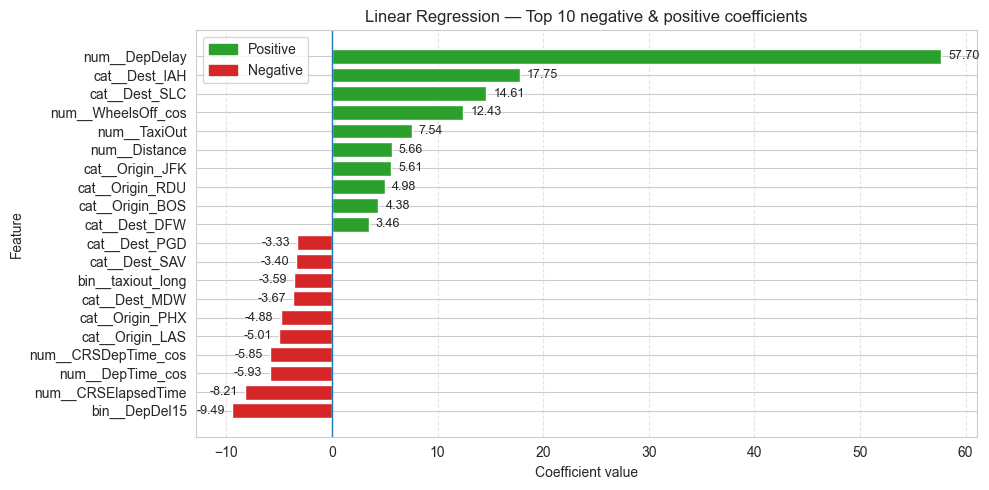

In [27]:
coef_df_lr = get_linear_coef_df_from_pipeline(clf_best_lr, include_intercept=True)

plot_top_pos_neg_coefs_colored(
    coef_df_lr,
    top_k=10,
    title="Linear Regression — Top 10 negative & positive coefficients",
    show_values=True,
    value_fmt="{:.2f}",
    save=True,
    save_dir="img/regr/coef_plots",
    filename="linreg_top10_pos_neg_colored"
)


# Evaluation of LinReg Model


--- Validation metrics (regression) — LinRegr ---
Saved plot → img/regr/reg_plots\linregr_scatter_true_vs_pred.png


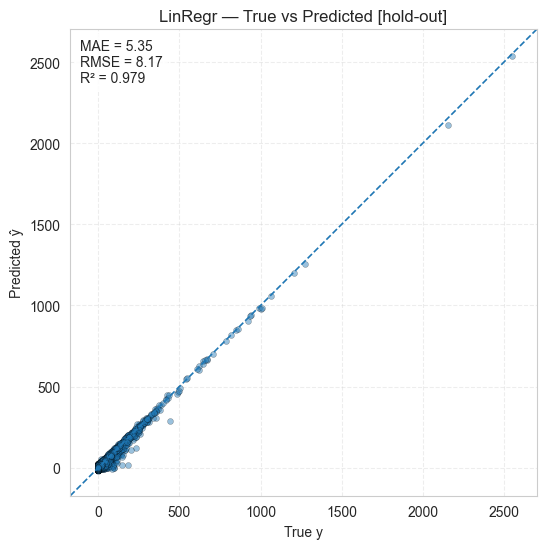

Saved plot → img/regr/reg_plots\linregr_residuals.png


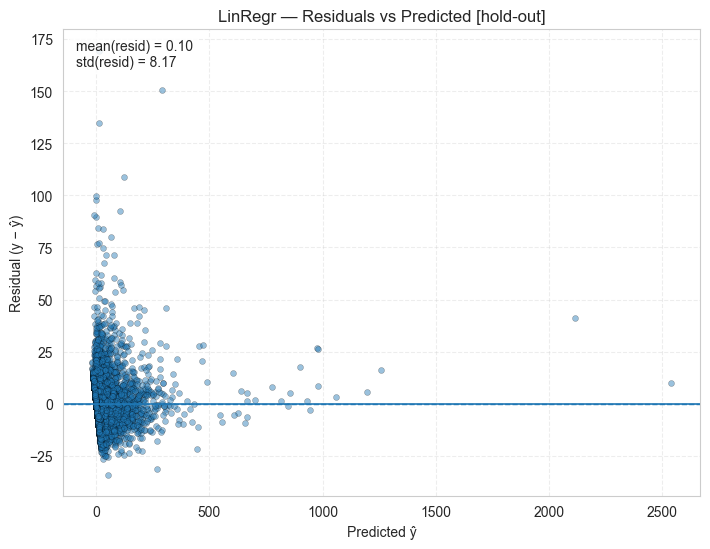

,LinRegr
MAE,5.351
MSE,66.738
RMSE,8.169
RAE,0.244
RRSE,0.146
R2,0.979
Adjusted_R2,0.979
Corr,0.989


In [31]:
lr_best_scores = model_evaluation('LinRegr', clf_best_lr, X_valid, y_valid,scatter_plot=True, resid_plot=True, save_plots=True)
lr_best_scores.T

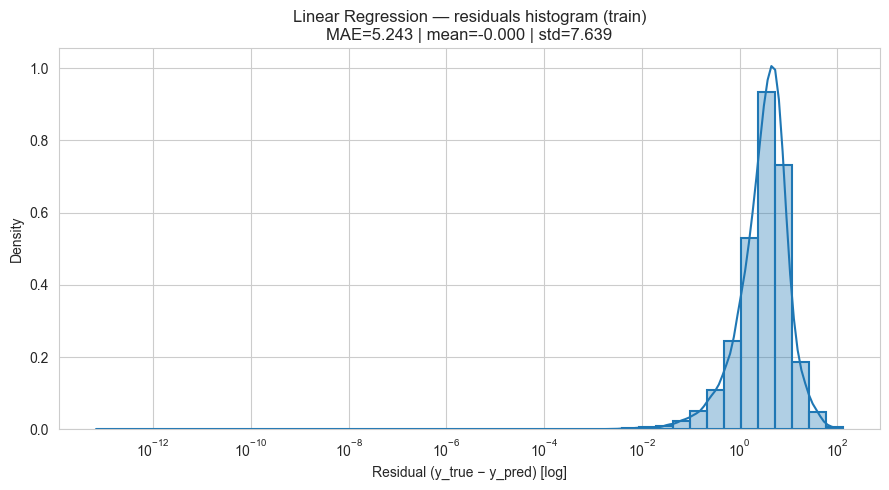

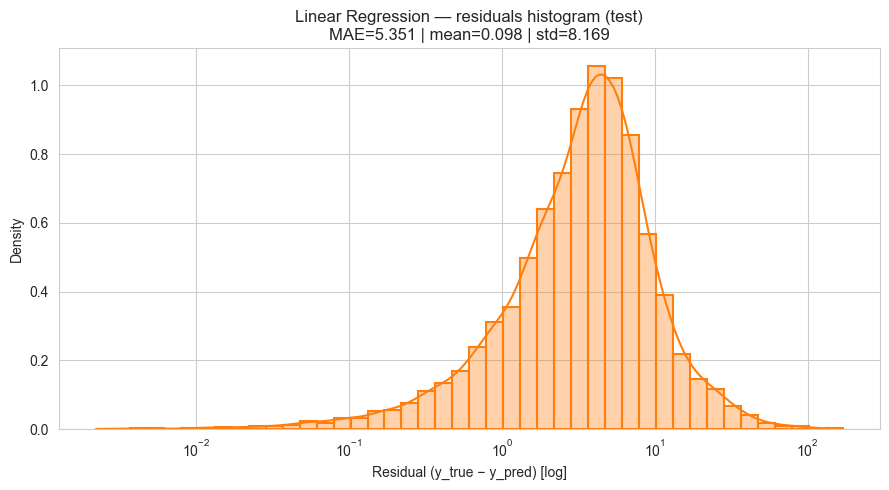

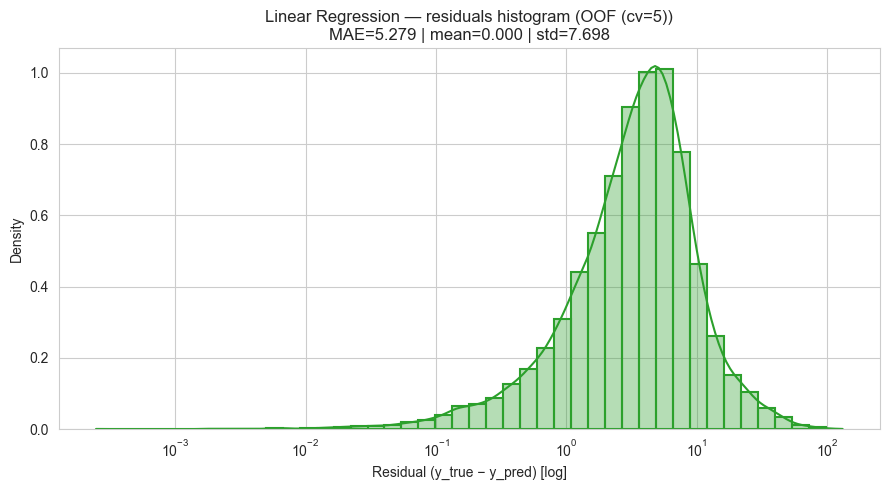

{'train': {'residuals': array([ 0.57470199, -7.42484378,  1.53024163, ...,  4.07124598,
         -1.39463429, -2.27959045], shape=(31837,)),
  'mae': 5.242881689731056,
  'mean': -7.722970389246004e-15,
  'std': 7.639313894571174},
 'test': {'residuals': array([-2.74990032,  2.43907781, -2.8784026 , ...,  5.00660841,
          4.42061672, -1.40359609], shape=(15681,)),
  'mae': 5.350586603070966,
  'mean': 0.09788171348282762,
  'std': 8.168764253106136},
 'oof': {'residuals': array([ 0.54375399, -7.16163073,  1.83534376, ...,  4.19283826,
         -1.49583511, -2.18501877], shape=(31837,)),
  'mae': 5.279018526346806,
  'mean': 0.0001373762661883274,
  'std': 7.69817192792482}}

In [35]:
plot_residuals_sns_3plots(
    clf_best_lr,
    X_train, y_train,
    X_valid, y_valid,
    cv=5,
    bins=44,
    kde=True,
    clip_percentile=(0, 100),
    model_label='Linear Regression'
)


## saving model

In [36]:
# save model
save_model("LinReg", lr_best_scores, SCORING_LinReg, RANDOM_STATE_LinReg, CV_SPLITS_LinReg, grid=grid_lr)

---

# LassoCV tuned

---

In [37]:
pipe_lasso = make_pipe(LassoCV(alphas=np.logspace(-4, 1, 200),
                               cv=CV_SPLITS_LinReg,
                               n_jobs=-1,
                               random_state=RANDOM_STATE_LinReg,
                               max_iter=5000), use_smote=False, use_fs=False)

# Training
pipe_lasso.fit(X_train, y_train)

clf_best_lasso = pipe_lasso

print(f"Chosen alpha_: {clf_best_lasso.named_steps['model'].alpha_}")

Chosen alpha_: 0.0014314589375234786


In [38]:
print(f"Intercept: {clf_best_lasso.named_steps['model'].intercept_}")

Intercept: 15.76000812408552


Saved plot → img/regr/coef_plots\LassoReg_top10_pos_neg_colored.png


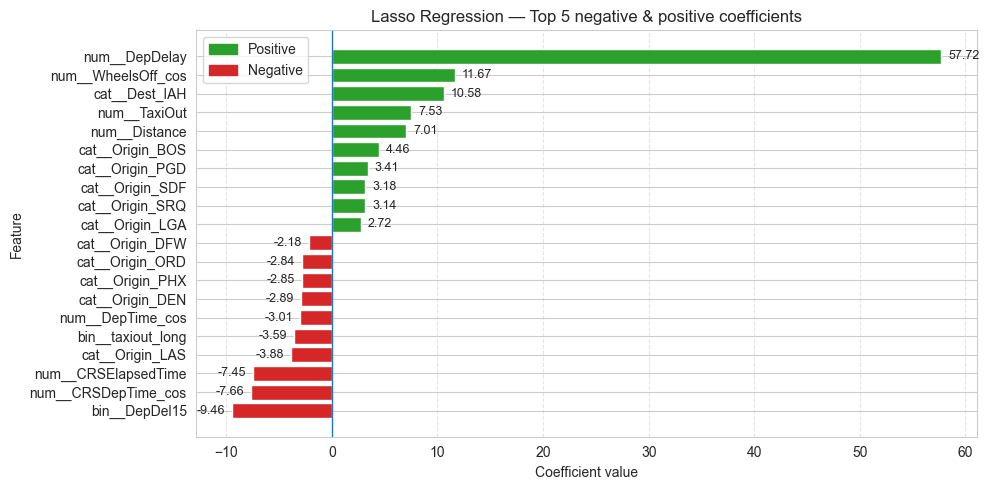

In [39]:
coef_df_lasso = get_linear_coef_df_from_pipeline(clf_best_lasso, include_intercept=True)

plot_top_pos_neg_coefs_colored(
    coef_df_lasso,
    top_k=10,
    title="Lasso Regression — Top 5 negative & positive coefficients",
    show_values=True,
    value_fmt="{:.2f}",
    save=True,
    save_dir="img/regr/coef_plots",
    filename="LassoReg_top10_pos_neg_colored"
)

In [40]:
m = clf_best_lasso.named_steps["model"]

alpha = m.alpha_
n_total = coef_df_lasso.shape[0]

zero_mask = coef_df_lasso["coef"] == 0
n_zero = int(zero_mask.sum())
n_nonzero = n_total - n_zero
pct_zero = 100 * n_zero / n_total

print(f"Chosen alpha_: {alpha}")
print(f"Non-zero coefs: {n_nonzero}/{n_total} ({100 - pct_zero:.1f}%)")
print(f"Zero coefs:     {n_zero}/{n_total} ({pct_zero:.1f}%)")

Chosen alpha_: 0.0014314589375234786
Non-zero coefs: 117/165 (70.9%)
Zero coefs:     48/165 (29.1%)


In [41]:
zero_features = coef_df_lasso.loc[zero_mask, "feature"].tolist()

print(f"Zero-coefficient features: {zero_features}")

Zero-coefficient features: ['cat__Origin_MDW', 'cat__Origin_MYR', 'cat__Origin_PHL', 'cat__Origin_RSW', 'cat__Origin_MCO', 'cat__Dest_AUS', 'cat__Dest_JFK', 'cat__Dest_SDF', 'cat__Dest_ATL', 'cat__Dest_DAL', 'cat__Dest_DCA', 'cat__Origin_SAV', 'cat__Dest_PIE', 'cat__Dest_SFO', 'cat__Dest_SRQ', 'cat__Dest_SLC', 'cat__DepTimeBlk_0600-0659', 'cat__Dest_SAV', 'cat__Dest_RSW', 'cat__Dest_RDU', 'cat__Dest_LGA', 'cat__Dest_MYR', 'cat__Dest_LAX', 'cat__DepTimeBlk_1800-1859', 'cat__HourlyWeatherType_other', 'cat__HourlyWeatherType_rain', 'bin__dep_delay_gt30', 'bin__is_evening_departure', 'cat__DepTimeBlk_1300-1359', 'cat__DepTimeBlk_2200-2259', 'cat__Origin_SFO', 'cat__Dest_BOS', 'cat__Origin_RDU', 'cat__Origin_IAH', 'cat__Origin_DAL', 'cat__Origin_AUS', 'cat__Reporting_Airline_9E', 'cat__Reporting_Airline_OH', 'cat__Origin_HOU', 'num__CRSDepTime_sin', 'num__DepTime_sin', 'cat__Origin_JFK', 'cat__Origin_FLL', 'cat__Dest_VPS', 'cat__DepTimeBlk_1000-1059', 'cat__DepTimeBlk_0900-0959', 'cat__DepT

## Evaluation LassoCV


--- Validation metrics (regression) — Lasso_Regression ---
Saved plot → img/regr/reg_plots\lasso_regression_scatter_true_vs_pred.png


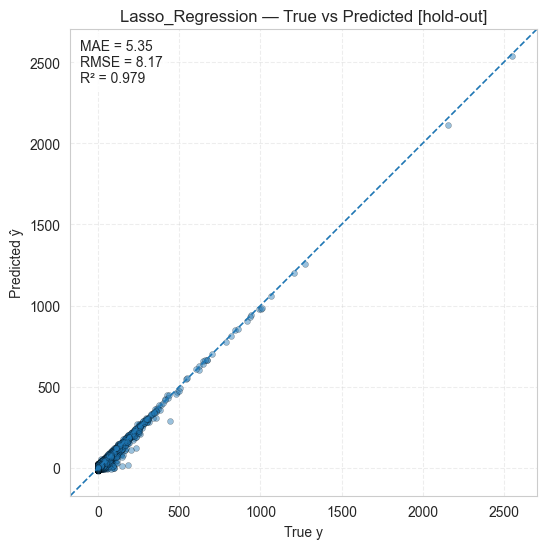

Saved plot → img/regr/reg_plots\lasso_regression_residuals.png


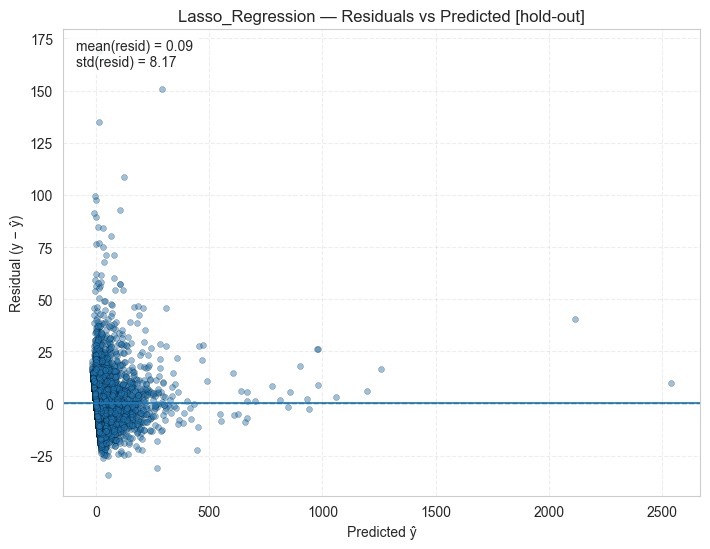

,Lasso_Regression
MAE,5.350
MSE,66.790
RMSE,8.172
RAE,0.244
RRSE,0.146
R2,0.979
Adjusted_R2,0.979
Corr,0.989


In [42]:
lasso_best_scores = model_evaluation('Lasso_Regression', clf_best_lasso, X_valid, y_valid,scatter_plot=True, resid_plot=True, save_plots=True)
lasso_best_scores.T

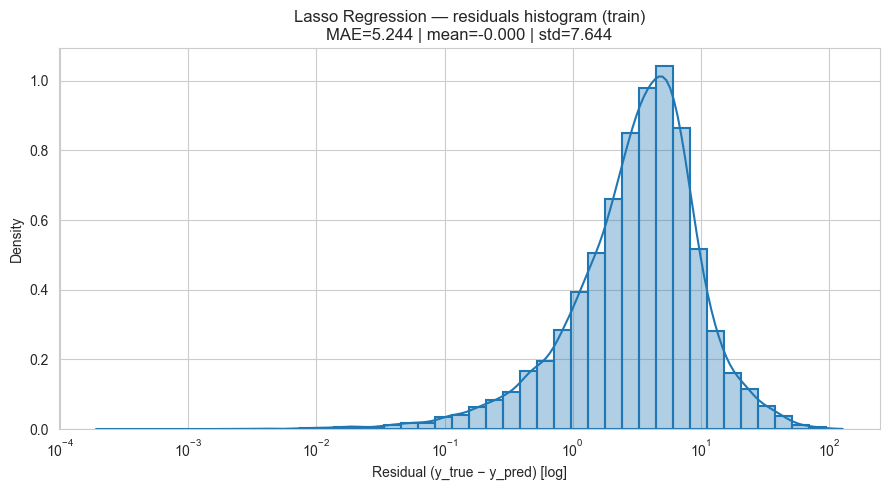

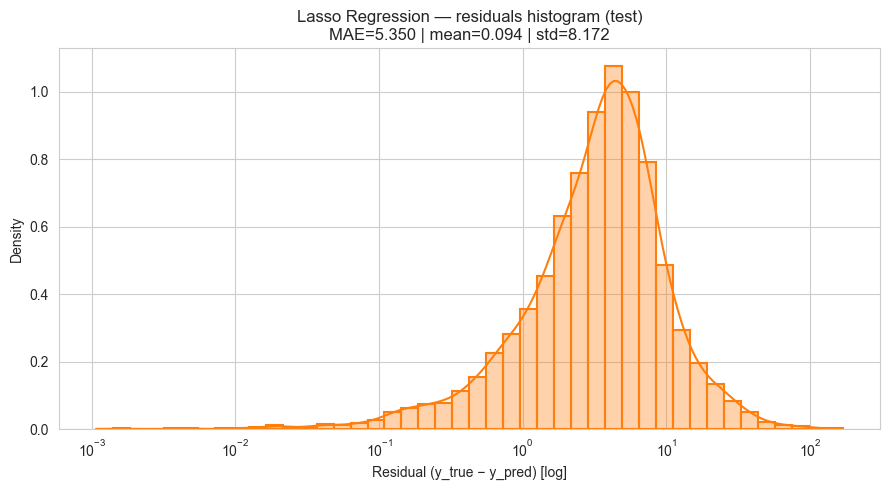

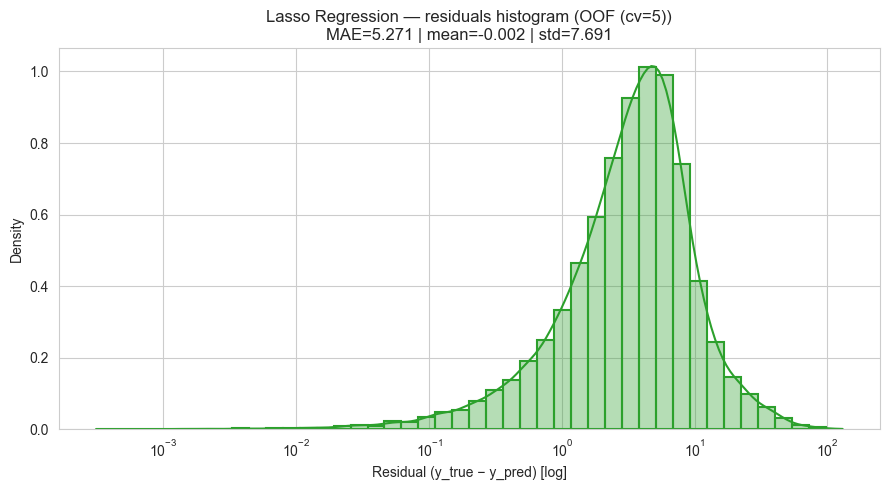

{'train': {'residuals': array([ 0.48239288, -7.25537418,  1.61666608, ...,  3.87683421,
         -1.39402844, -2.23802014], shape=(31837,)),
  'mae': 5.244427720841859,
  'mean': -6.204443903047016e-16,
  'std': 7.644295265047237},
 'test': {'residuals': array([-2.89775526,  2.53818541, -2.78012472, ...,  5.03291374,
          4.7397397 , -1.41303815], shape=(15681,)),
  'mae': 5.3500520063865995,
  'mean': 0.09387002352899672,
  'std': 8.171954887702936},
 'oof': {'residuals': array([ 0.44491132, -6.93933644,  1.89558408, ...,  4.00997524,
         -1.48039399, -2.14019895], shape=(31837,)),
  'mae': 5.271188131336658,
  'mean': -0.001784816776432811,
  'std': 7.691126546946337}}

In [43]:
plot_residuals_sns_3plots(
    clf_best_lasso,  
    X_train, y_train,
    X_valid, y_valid,
    cv=5,
    bins=44,
    kde=True,
    clip_percentile=(0, 100),
    model_label='Lasso Regression'
)

## Save LassoCV model

In [44]:
# save model
save_model("LassoReg", lasso_best_scores, SCORING_LinReg, RANDOM_STATE_LinReg, CV_SPLITS_LinReg, model_clf=clf_best_lasso)

---

# RidgeCV tuned

In [47]:
pipe_ridge = make_pipe(RidgeCV(alphas=np.logspace(-4, 2, 200),
                               cv=CV_SPLITS_LinReg,
                               scoring=SCORING_LinReg,
                               fit_intercept=True), use_smote=False, use_fs=False)

# Training
pipe_ridge.fit(X_train, y_train)

clf_best_ridge = pipe_ridge

print(f"Chosen alpha_: {clf_best_ridge.named_steps['model'].alpha_}")

Chosen alpha_: 13.354515629298973


In [48]:
print(f"Chosen intercept_: {clf_best_ridge.named_steps['model'].intercept_}")

Chosen intercept_: 18.22766799611827


Saved plot → img/regr/coef_plots\RidgeReg_top10_pos_neg_colored.png


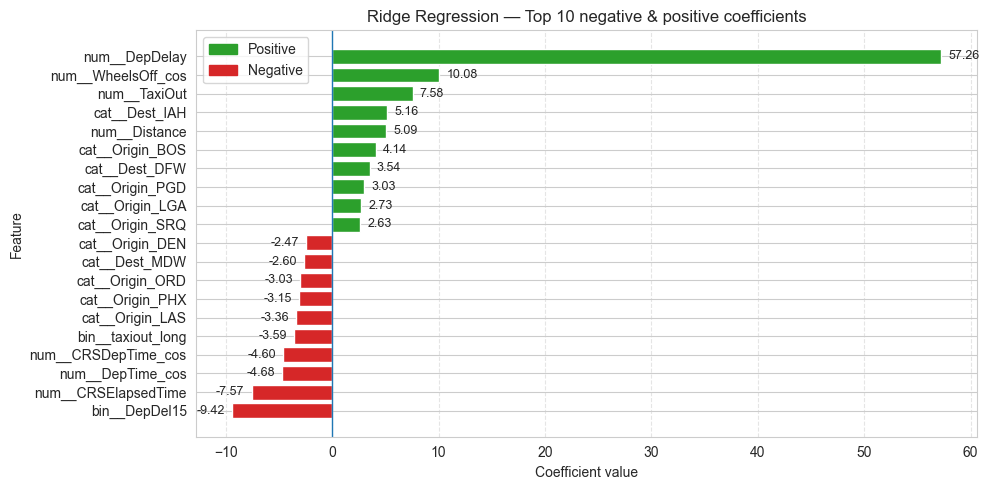

In [49]:
coef_df_ridge = get_linear_coef_df_from_pipeline(clf_best_ridge, include_intercept=True)

plot_top_pos_neg_coefs_colored(
    coef_df_ridge,
    top_k=10,
    title="Ridge Regression — Top 10 negative & positive coefficients",
    show_values=True,
    value_fmt="{:.2f}",
    save=True,
    save_dir="img/regr/coef_plots",
    filename="RidgeReg_top10_pos_neg_colored"
)

In [50]:
m = clf_best_ridge.named_steps["model"]

alpha = m.alpha_
n_total = coef_df_ridge.shape[0]

close_to_zero_mask = coef_df_ridge["coef"] <= 0.00001
n_zero = int(close_to_zero_mask.sum())
n_nonzero = n_total - n_zero
pct_zero = 100 * n_zero / n_total

print(f"Chosen alpha_: {alpha}")
print(f"Non-zero coefs: {n_nonzero}/{n_total} ({100 - pct_zero:.1f}%)")
print(f"Close to Zero coefs:     {n_zero}/{n_total} ({pct_zero:.1f}%)")

Chosen alpha_: 13.354515629298973
Non-zero coefs: 82/165 (49.7%)
Close to Zero coefs:     83/165 (50.3%)


## Evaluation RidgeCV


--- Validation metrics (regression) — Ridge_Regression ---
Saved plot → img/regr/reg_plots\ridge_regression_scatter_true_vs_pred.png


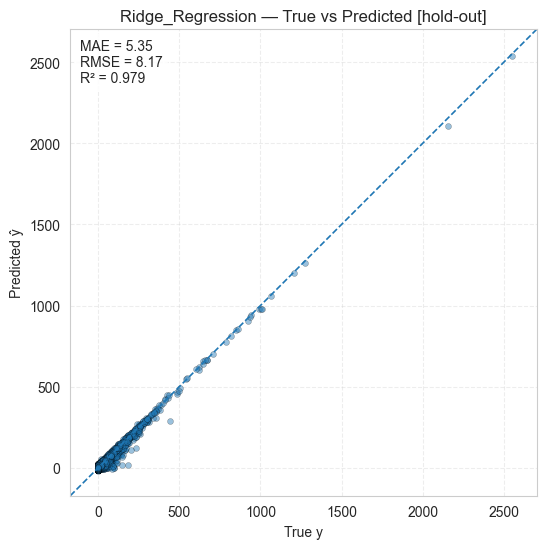

Saved plot → img/regr/reg_plots\ridge_regression_residuals.png


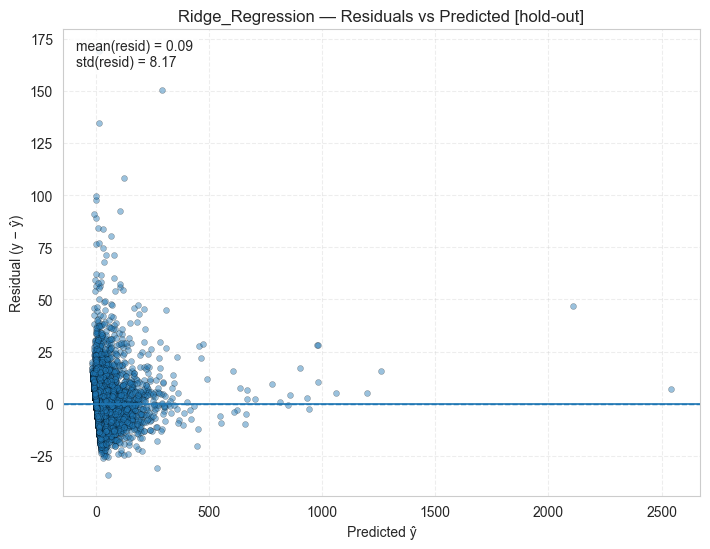

,Ridge_Regression
MAE,5.348
MSE,66.702
RMSE,8.167
RAE,0.244
RRSE,0.146
R2,0.979
Adjusted_R2,0.979
Corr,0.989


In [51]:
ridge_best_scores = model_evaluation('Ridge_Regression', clf_best_ridge, X_valid, y_valid,scatter_plot=True, resid_plot=True, save_plots=True)
ridge_best_scores.T

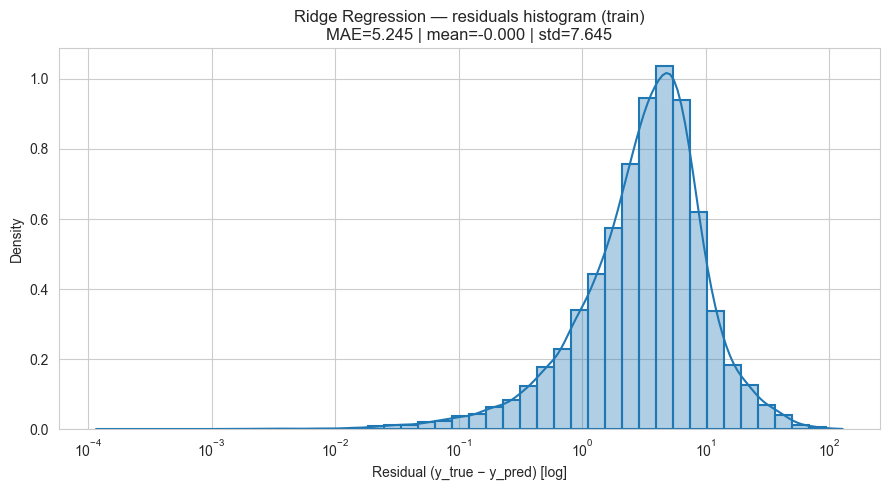

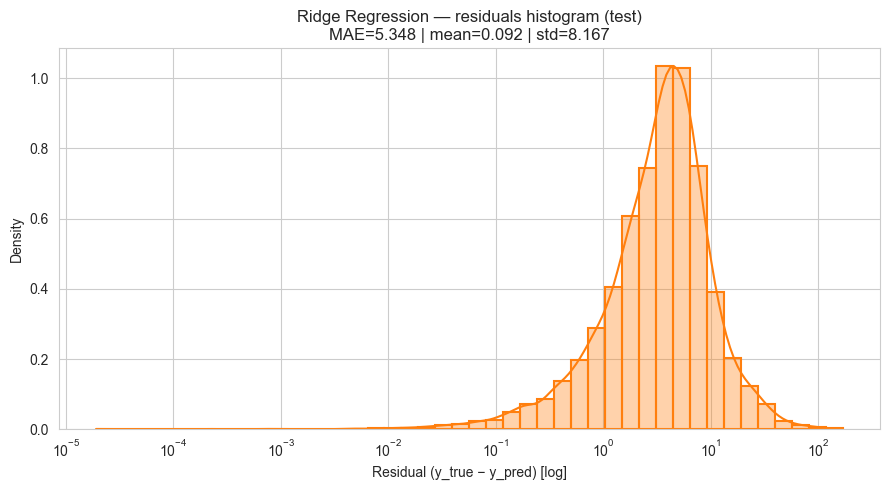

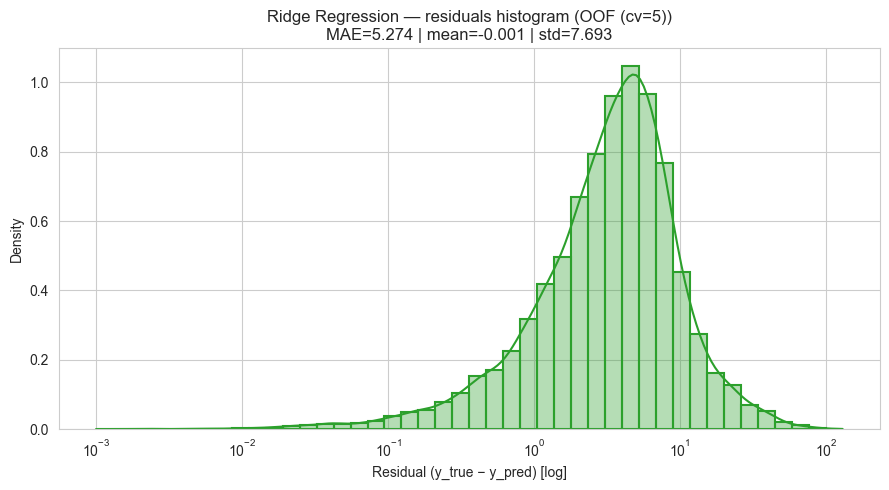

{'train': {'residuals': array([ 0.68562598, -7.2564172 ,  1.70550944, ...,  3.79616667,
         -1.37432417, -2.31982167], shape=(31837,)),
  'mae': 5.244616388535597,
  'mean': -8.619267033657402e-15,
  'std': 7.6447878349054585},
 'test': {'residuals': array([-2.80908747,  2.42970531, -2.86716084, ...,  5.22220542,
          4.67703421, -1.51880079], shape=(15681,)),
  'mae': 5.348228891010547,
  'mean': 0.09160312524763163,
  'std': 8.166586940671753},
 'oof': {'residuals': array([ 0.6378903 , -6.99701469,  1.97759978, ...,  3.95243025,
         -1.46127103, -2.23691321], shape=(31837,)),
  'mae': 5.274357582393517,
  'mean': -0.0008160504666862977,
  'std': 7.692914785945118}}

In [52]:
plot_residuals_sns_3plots(
    clf_best_ridge,  
    X_train, y_train,
    X_valid, y_valid,
    cv=5,
    bins=44,
    kde=True,
    clip_percentile=(0, 100),
    model_label='Ridge Regression'
)

## Save RidgeCV model

In [53]:
# save model
save_model("RidgeReg", ridge_best_scores, SCORING_LinReg, RANDOM_STATE_LinReg, CV_SPLITS_LinReg, model_clf=clf_best_ridge)

---

# Random Forest Tuned

---

In [62]:
SCORING_RF = "neg_mean_absolute_error"
CV_SPLITS_RF = 2
RANDOM_STATE_RF = 33

pipe_rf = make_pipe(RandomForestRegressor(), use_smote=False, use_fs=False)

rf_grid_params = {
        # default
        "model__criterion": ['squared_error'],
        "model__n_estimators": [300],
        "model__random_state": [RANDOM_STATE_RF],
        "model__n_jobs": [-1],
        "model__max_depth": [None],
    
        # For tune
        #"model__min_samples_split": [100, 200, 300, 350],
        #"model__min_samples_leaf": [110, 200, 220],
        #"model__max_features": ["sqrt", None],
        #"model__max_samples": [0.5, 0.7, 1.0],
    }

# Training
grid_rf = GridSearchCV(estimator=pipe_rf, param_grid=rf_grid_params,
                       scoring=SCORING_RF, cv=CV_SPLITS_RF, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_rf.fit(X_train, y_train)

clf_best_rf = grid_rf.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


In [63]:
grid_rf.best_params_

{'model__criterion': 'squared_error',
 'model__max_depth': None,
 'model__n_estimators': 300,
 'model__n_jobs': -1,
 'model__random_state': 33}

# Evaluation of RF Model


--- Validation metrics (regression) — RF_regr ---
Saved plot → img/regr/reg_plots\rf_regr_scatter_true_vs_pred.png


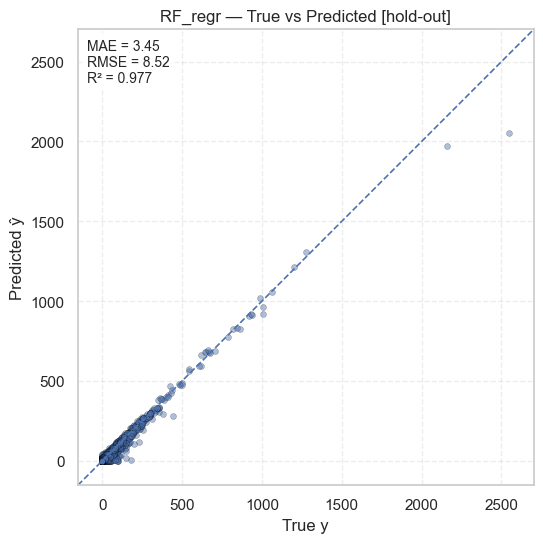

Saved plot → img/regr/reg_plots\rf_regr_residuals.png


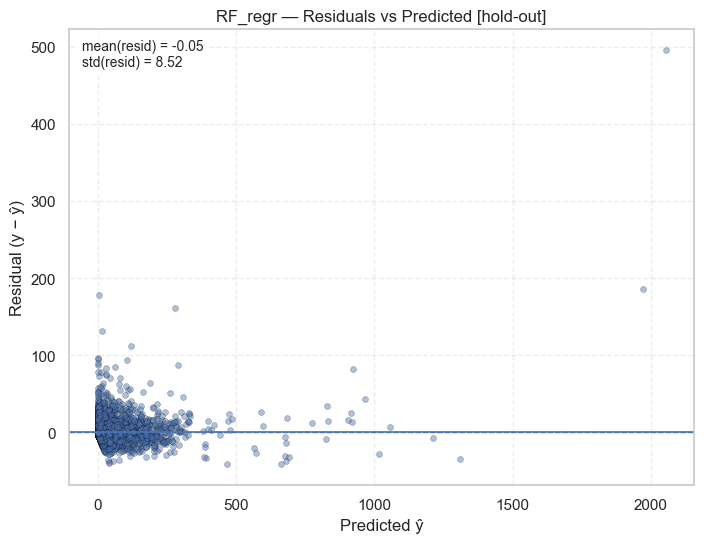

,RF_regr
MAE,3.451
MSE,72.587
RMSE,8.520
RAE,0.157
RRSE,0.152
R2,0.977
Adjusted_R2,0.977
Corr,0.989


In [64]:
rf_best_scores = model_evaluation('RF_regr', clf_best_rf, X_valid, y_valid, scatter_plot=True, resid_plot=True, save_plots=True)
rf_best_scores.T

C:\Users\Desmo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


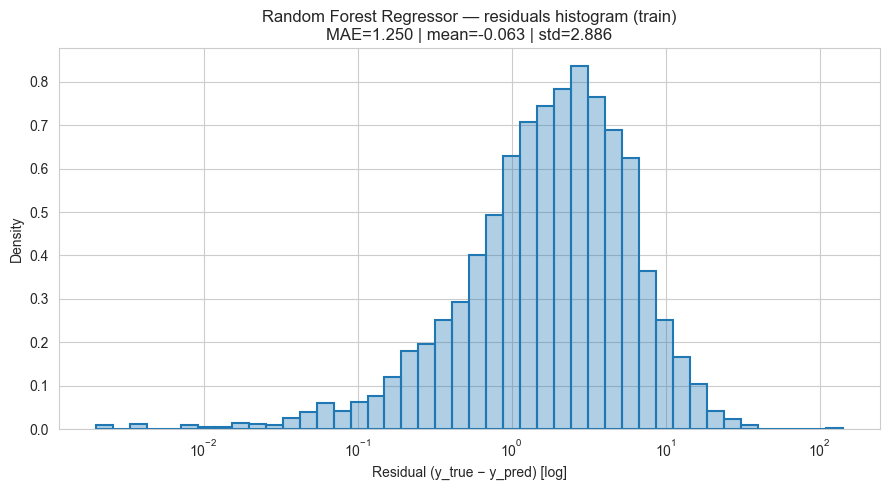

C:\Users\Desmo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


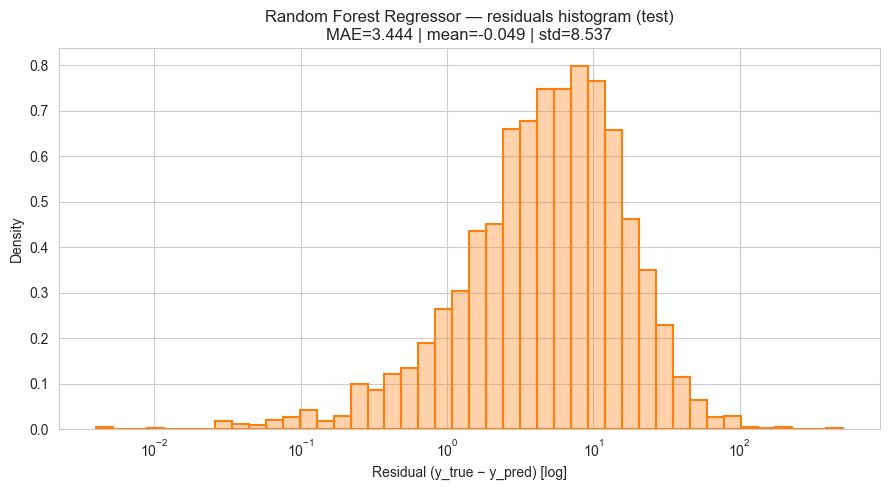

C:\Users\Desmo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


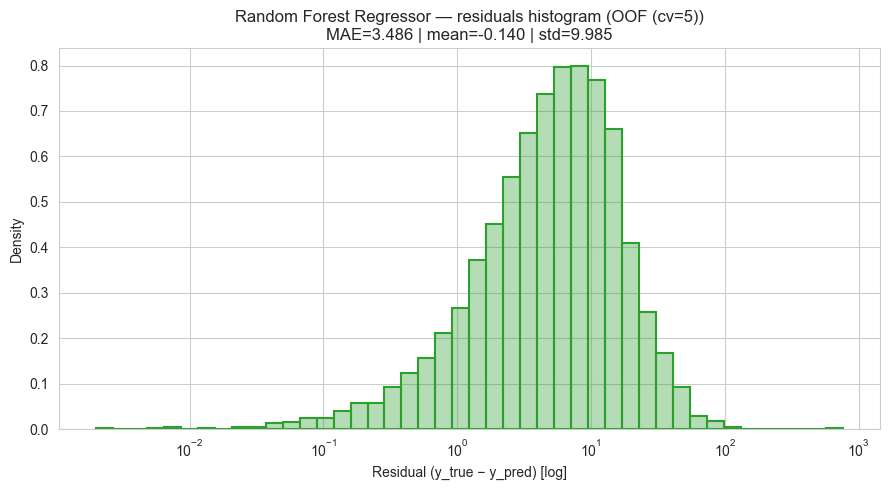

{'train': {'residuals': array([-0.074, -0.376,  0.   , ..., -0.746, -0.376, -0.624],
        shape=(31837,)),
  'mae': 1.2504675691805132,
  'mean': -0.06293834218048182,
  'std': 2.8856437365167302},
 'test': {'residuals': array([-0.822, -0.14 , -0.954, ..., -0.048, -0.454, -0.486],
        shape=(15681,)),
  'mae': 3.4444490785026467,
  'mean': -0.04871564313500415,
  'std': 8.53662124765643},
 'oof': {'residuals': array([-0.228, -1.47 , -0.078, ..., -0.948, -0.408, -0.892],
        shape=(31837,)),
  'mae': 3.48569299871219,
  'mean': -0.1398347834280868,
  'std': 9.984743905870358}}

In [57]:
plot_residuals_sns_3plots(
    clf_best_rf,  
    X_train, y_train,
    X_valid, y_valid,
    cv=5,
    bins=44,
    kde=True,
    clip_percentile=(0, 100),
    model_label='Random Forest Regressor'
)

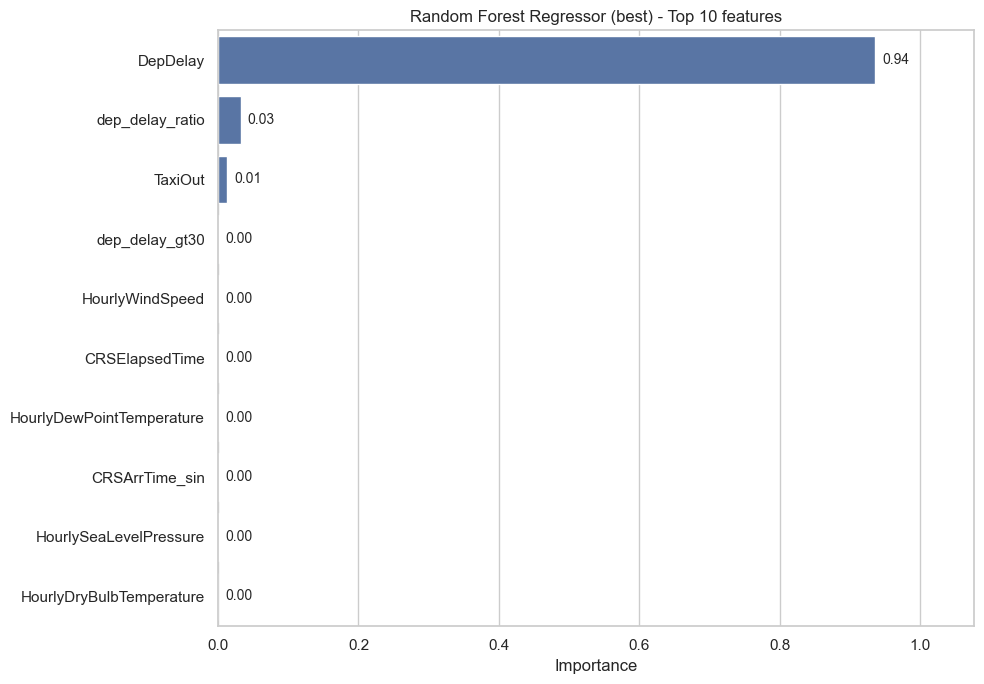

In [60]:
fig, ax, fi_df = plot_feature_importance(
     clf_best_rf,
     feature_names=X_train_encoded_features, 
     top_n=10,
     title="Random Forest Regressor (best) - Top 10 features",
     save_path="img/regr/feat_imp/regression_rf_top10.png",
     value_fmt="{:.2f}", 
)
plt.show()

# save model

In [59]:
# save model
save_model("RF", rf_best_scores, SCORING_RF, RANDOM_STATE_RF, CV_SPLITS_RF, grid=grid_rf)

---

# XGBoost Tuned

---

## Randomized Search CV approach

In [68]:
SCORING_XGB = "neg_mean_absolute_error"
CV_SPLITS_XGB = 5
RANDOM_STATE_XGB = 33

pipe_xgb = make_pipe(XGBRegressor(), use_smote=False, use_fs=False)

xgb_grid_params = {
        # Default
        "model__n_estimators": [500],
        "model__objective": ["reg:absoluteerror"],
        "model__n_jobs": [-1],
        "model__verbosity": [0],
    
        # For tune
        "model__max_depth": range(3, 15, 3),
        "model__colsample_by_tree": [0.05, 0.1, 0.2, 0.3, 0.5, 0.9],
    }

# Training
grid_xgb = GridSearchCV(estimator=pipe_xgb, param_grid=xgb_grid_params,
                       scoring=SCORING_XGB, cv=CV_SPLITS_XGB, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_xgb.fit(X_train, y_train)

clf_best_xgb = grid_xgb.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [69]:
grid_xgb.best_params_

{'model__colsample_by_tree': 0.05,
 'model__max_depth': 6,
 'model__n_estimators': 500,
 'model__n_jobs': -1,
 'model__objective': 'reg:absoluteerror',
 'model__verbosity': 0}

# Evaluate XGB Model


--- Validation metrics (regression) — XGB_regr ---
Saved plot → img/regr/reg_plots\xgb_regr_scatter_true_vs_pred.png


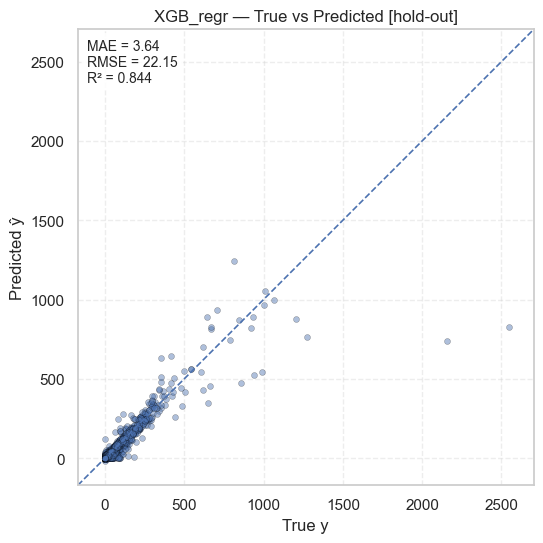

Saved plot → img/regr/reg_plots\xgb_regr_residuals.png


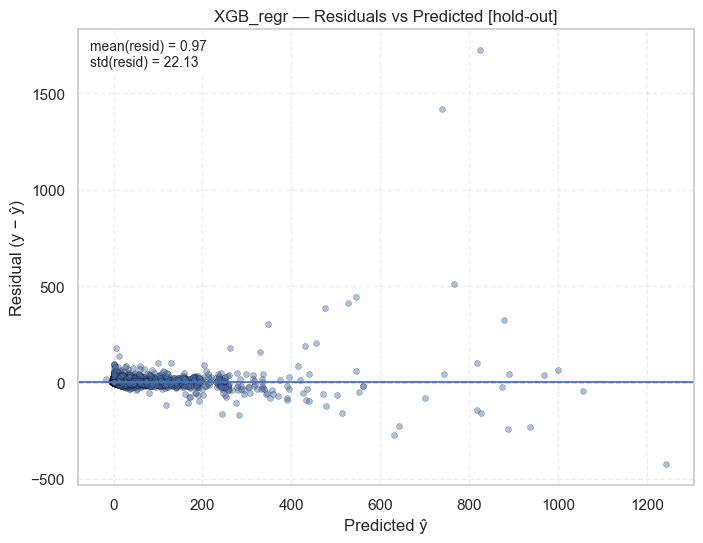

,XGB_regr
MAE,3.636
MSE,490.832
RMSE,22.155
RAE,0.166
RRSE,0.395
R2,0.844
Adjusted_R2,0.842
Corr,0.920


In [70]:
xgb_best_scores = model_evaluation('XGB_regr', clf_best_xgb, X_valid, y_valid, scatter_plot=True, resid_plot=True, save_plots=True)
xgb_best_scores.T

C:\Users\Desmo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


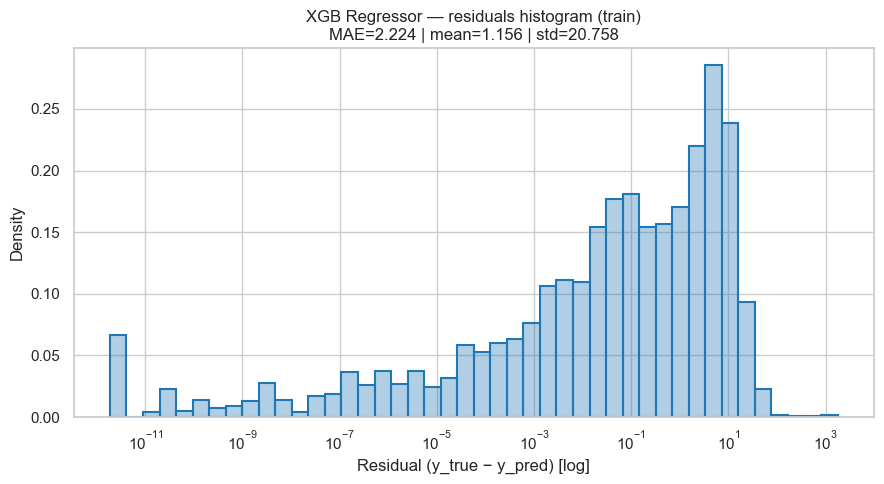

C:\Users\Desmo\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


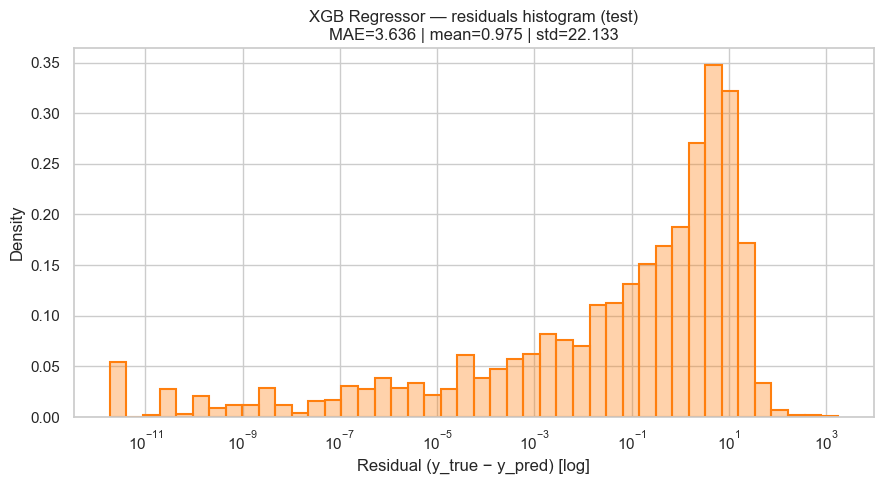

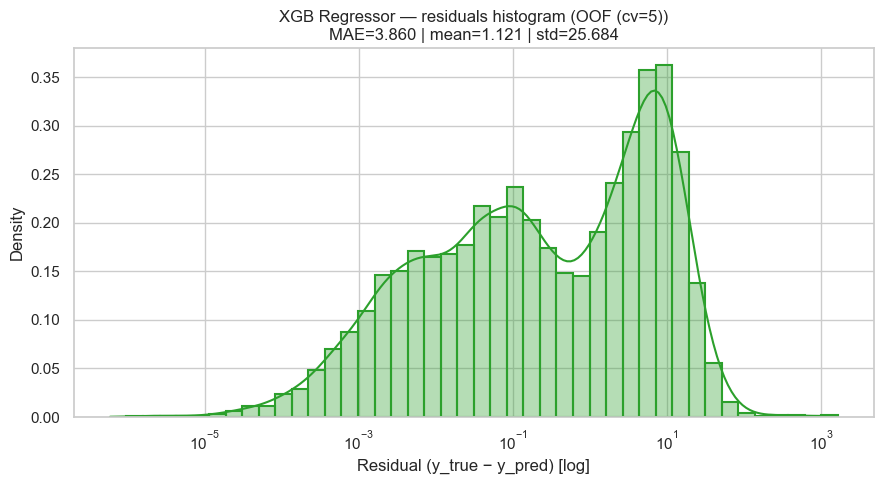

{'train': {'residuals': array([ 0.00762621, -0.37867355,  0.        , ..., -0.00194119,
         -0.10776539,  0.04295749], shape=(31837,)),
  'mae': 2.2238590539453558,
  'mean': 1.1562955012310885,
  'std': 20.758206396738355},
 'test': {'residuals': array([ 0.5762561 ,  0.00172671, -0.7837534 , ...,  0.00114707,
         -0.02046695, -0.15574649], shape=(15681,)),
  'mae': 3.63550769654225,
  'mean': 0.974944724445215,
  'std': 22.133268261488563},
 'oof': {'residuals': array([ 0.00631432,  2.85120773, -0.01339247, ..., -1.63881648,
          0.2655535 ,  0.00762394], shape=(31837,)),
  'mae': 3.859734310563076,
  'mean': 1.1211125061591636,
  'std': 25.68439446675052}}

In [71]:
plot_residuals_sns_3plots(
    clf_best_xgb,  
    X_train, y_train,
    X_valid, y_valid,
    cv=5,
    bins=44,
    kde=True,
    clip_percentile=(1, 100),
    model_label='XGB Regressor'
)

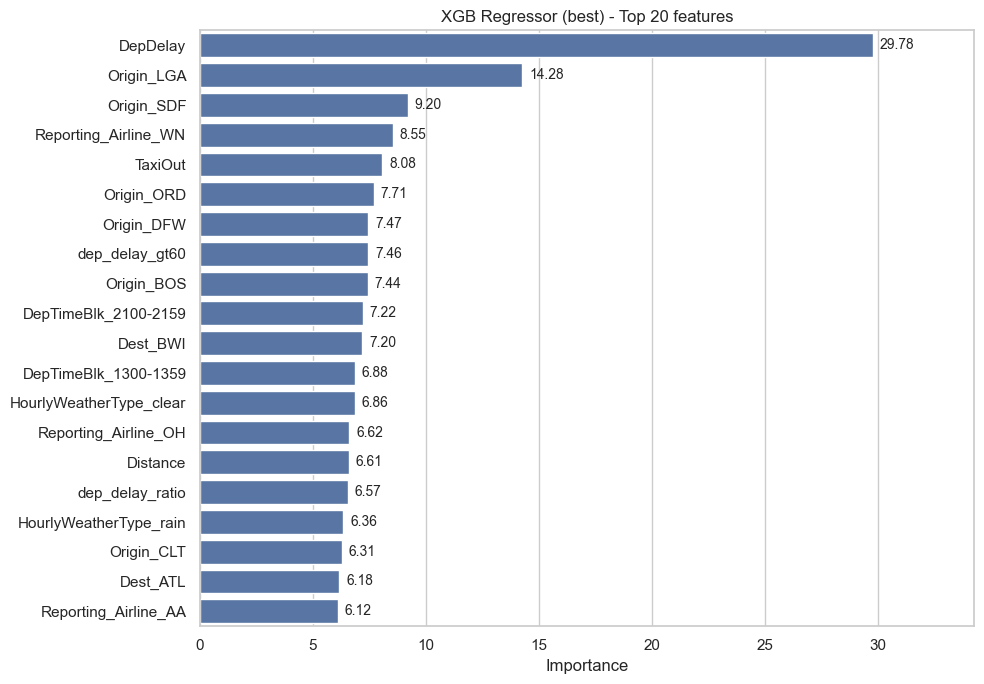

In [72]:
fig, ax, fi_df = plot_feature_importance(
     clf_best_xgb,
     feature_names=X_train_encoded_features,
     top_n=20,
     title="XGB Regressor (best) - Top 20 features",
     save_path="img/regr/feat_imp/regression_xgb_top20.png",
     value_fmt="{:.2f}",      
)
plt.show()

In [75]:
path = save_dtreeviz_tree_from_pipeline(
    clf_best_xgb,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="img/trees_regr/xgb[0]_3_regr_best.svg",
    max_depth=3,
    tree_index=0
)
print("Saved:", path)

Saved: img/trees_regr/xgb[0]_3_regr_best.svg


In [76]:
path = save_dtreeviz_tree_from_pipeline(
    clf_best_xgb,
    X_train, y_train,
    class_names=("OnTime","Delayed"),
    target_name="ArrDel15",
    save_path="img/trees_regr/xgb[0]_MAX_regr_best.svg",
    max_depth=100,
    tree_index=0
)
print("Saved:", path)

Saved: img/trees_regr/xgb[0]_MAX_regr_best.svg


## save xgb model

In [77]:
# save model
save_model("XGB", xgb_best_scores, SCORING_XGB, RANDOM_STATE_XGB, CV_SPLITS_XGB, grid=grid_xgb)

---

## SVM (LinearSVR)

---

In [21]:
SCORING_SVR = "neg_mean_absolute_error"
CV_SPLITS_SVR = 3
RANDOM_STATE_SVR = 33

pipe_svr = make_pipe(LinearSVR(), use_smote=False, use_fs=False)

svr_grid_params = {
        # Default
        "model__max_iter": [5000],
        "model__epsilon": [0.0],
        "model__fit_intercept": [True],
        "model__random_state": [RANDOM_STATE_SVR],
        "model__C": np.logspace(-3, 2, 100),
    }

# Training
grid_svr = GridSearchCV(estimator=pipe_svr, param_grid=svr_grid_params,
                       scoring=SCORING_SVR, cv=CV_SPLITS_SVR, return_train_score=True,
                       n_jobs=-1, verbose=1)

grid_svr.fit(X_train, y_train)

clf_best_svr = grid_svr.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [22]:
grid_svr.best_params_, clf_best_svr.named_steps['model'].intercept_

({'model__C': np.float64(4.328761281083057),
  'model__epsilon': 0.0,
  'model__fit_intercept': True,
  'model__max_iter': 5000,
  'model__random_state': 33},
 array([8.3335392]))


--- Validation metrics (regression) — LinearSVR ---
Saved plot → img/regr/reg_plots\linearsvr_scatter_true_vs_pred.png


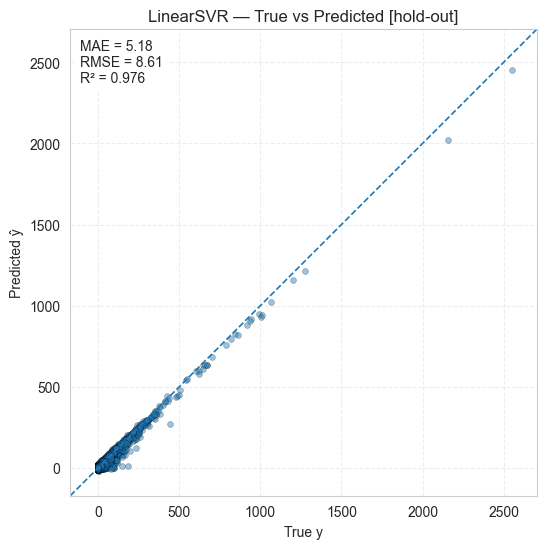

Saved plot → img/regr/reg_plots\linearsvr_residuals.png


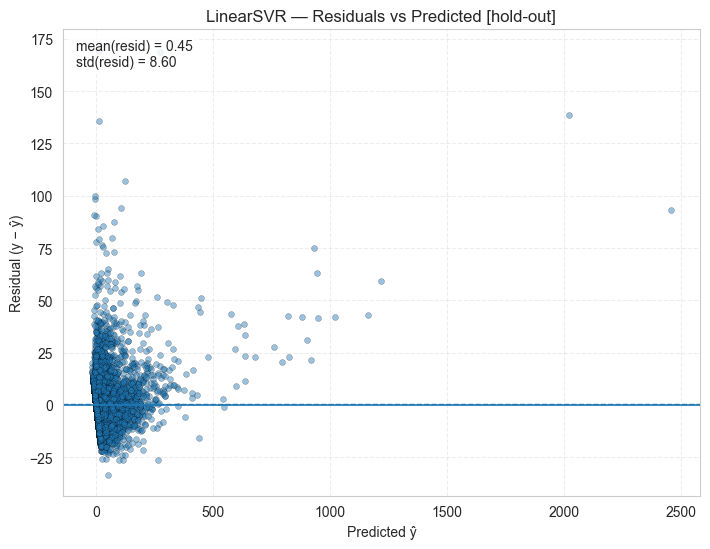

,LinearSVR
MAE,5.182
MSE,74.118
RMSE,8.609
RAE,0.236
RRSE,0.154
R2,0.976
Adjusted_R2,0.976
Corr,0.989


In [23]:
svr_best_scores = model_evaluation('LinearSVR', clf_best_svr, X_valid, y_valid, scatter_plot=True, resid_plot=True, save_plots=True)
svr_best_scores.T

Saved plot → img/regr/coef_plots\LinearSVR_top10_pos_neg_colored.png


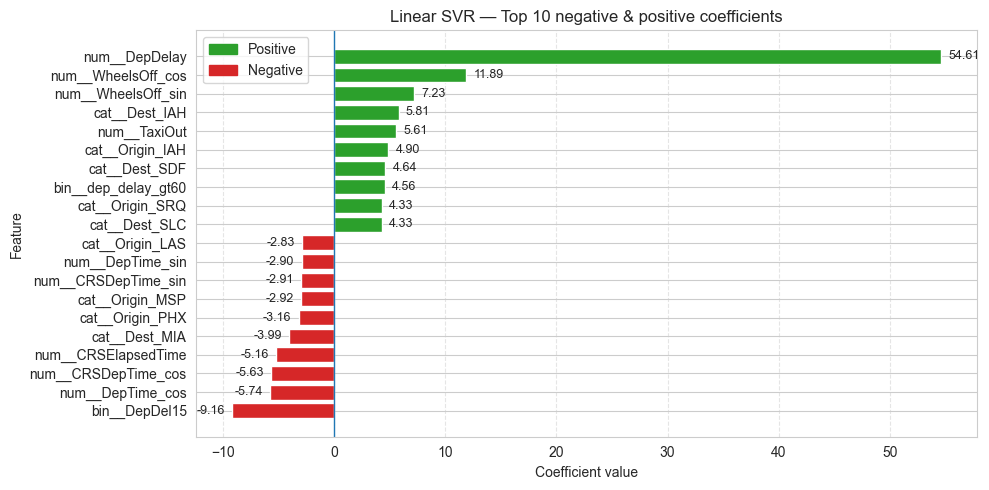

In [24]:
coef_df_svr = get_linear_coef_df_from_pipeline(clf_best_svr, include_intercept=True)

plot_top_pos_neg_coefs_colored(
    coef_df_svr,
    top_k=10,
    title="Linear SVR — Top 10 negative & positive coefficients",
    show_values=True,
    value_fmt="{:.2f}",
    save=True,
    save_dir="img/regr/coef_plots",
    filename="LinearSVR_top10_pos_neg_colored"
)

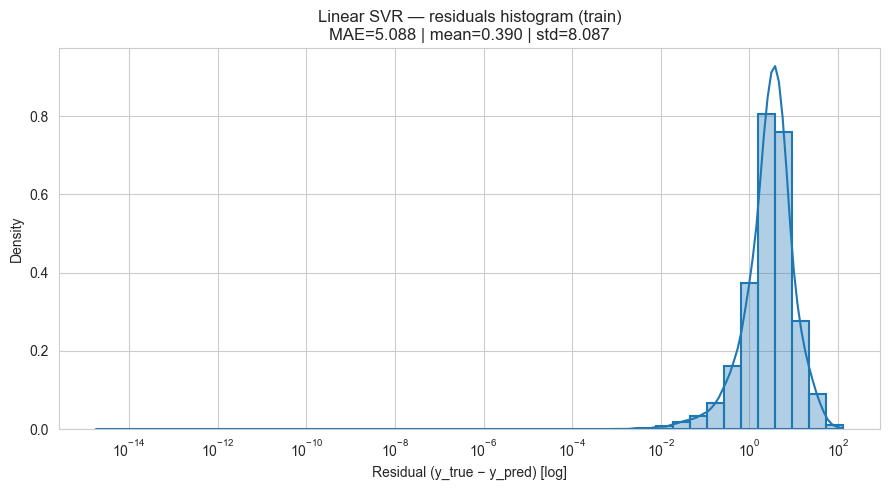

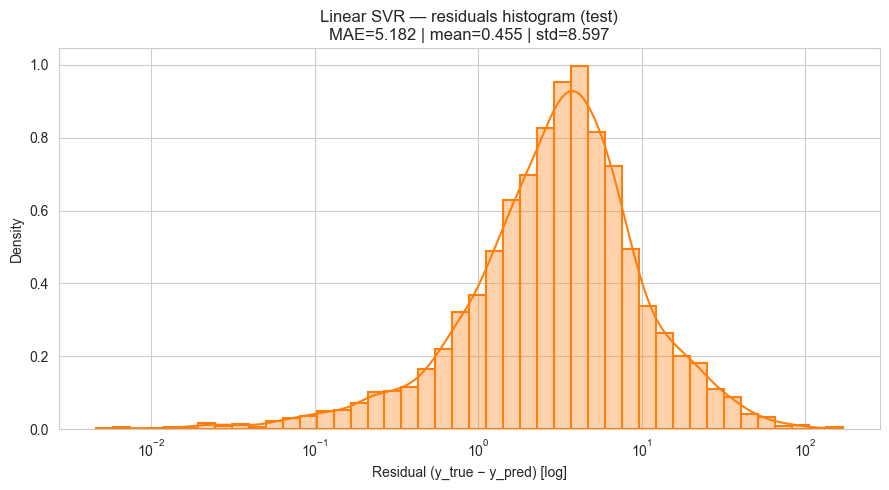

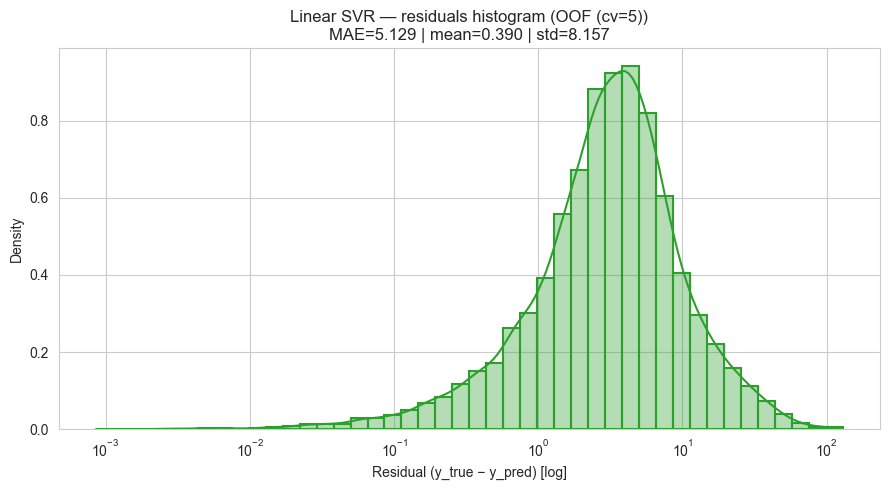

{'train': {'residuals': array([-0.61400335, -7.92982929,  1.41069047, ...,  3.28762662,
         -3.00493168, -3.12472092], shape=(31837,)),
  'mae': 5.087633949379796,
  'mean': 0.39043700902507006,
  'std': 8.086809272430692},
 'test': {'residuals': array([-3.50636384,  1.09130525, -3.04373584, ...,  4.0693137 ,
          4.84957786, -2.26265779], shape=(15681,)),
  'mae': 5.182150425022168,
  'mean': 0.4546761565641571,
  'std': 8.597152436312125},
 'oof': {'residuals': array([-0.9278254 , -7.69399297,  1.43429487, ...,  3.6108385 ,
         -3.32308945, -2.82160862], shape=(31837,)),
  'mae': 5.128519654897016,
  'mean': 0.3904416901350813,
  'std': 8.156989761253804}}

In [25]:
plot_residuals_sns_3plots(
    clf_best_svr,
    X_train, y_train,
    X_valid, y_valid,
    cv=5,
    bins=44,
    kde=True,
    clip_percentile=(0, 100),
    model_label='Linear SVR'
)

## Save LinearSVR model

In [26]:
# save model
save_model("LinearSVR", svr_best_scores, SCORING_SVR, RANDOM_STATE_SVR, CV_SPLITS_SVR, grid=grid_svr)

---

## Performance summary of all Tuned models
## INCLUDING Dep info , table - 8 

In [27]:
lr = joblib.load('models/regr/LinReg_dep_regr_artifact.joblib')
lr = lr['scores_df']

lasso = joblib.load('models/regr/LassoReg_dep_regr_artifact.joblib')
lasso = lasso['scores_df']

ridge = joblib.load('models/regr/RidgeReg_dep_regr_artifact.joblib')
ridge = ridge['scores_df']

rf = joblib.load('models/regr/RF_dep_regr_artifact.joblib')
rf = rf['scores_df']

xgb = joblib.load('models/regr/XGB_dep_regr_artifact.joblib')
xgb = xgb['scores_df']

svr = joblib.load('models/regr/LinearSVR_dep_regr_artifact.joblib')
svr = svr['scores_df']

In [28]:
performance_regression = pd.concat([lr, lasso, ridge, rf, xgb, svr], axis=0)
performance_regression = round(performance_regression, 2)
performance_regression.T

,LinRegr,Lasso_Regression,Ridge_Regression,RF_regr,XGB_regr,LinearSVR
MAE,5.35,5.35,5.35,3.44,3.64,5.18
MSE,66.74,66.79,66.70,72.88,490.83,74.12
RMSE,8.17,8.17,8.17,8.54,22.16,8.61
RAE,0.24,0.24,0.24,0.16,0.17,0.24
RRSE,0.15,0.15,0.15,0.15,0.40,0.15
R2,0.98,0.98,0.98,0.98,0.84,0.98
Adjusted_R2,0.98,0.98,0.98,0.98,0.84,0.98
Corr,0.99,0.99,0.99,0.99,0.92,0.99


In [29]:
performance_regression.to_csv('data/scores_regression_Dep.csv', index=True)

---